In [1]:
#Set Env
install.packages(c("gridExtra","GGally","corrplot","rpart.plot","NbClust","Boruta","e1071"), repos='http://cran.us.r-project.org')
library(dplyr)
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(caret)
library(MASS)
library(rpart)
library(corrplot)
library(rpart.plot)
library(randomForest)
library(NbClust)
library(stats)
library(Boruta)
library(e1071)
library(zoo)
#read data
df <- read_csv("indian_liver_patient.csv")
#set duplicate off for comparision and to have in case df is corrupted
dfReserve<-df

package 'gridExtra' successfully unpacked and MD5 sums checked
package 'GGally' successfully unpacked and MD5 sums checked
package 'corrplot' successfully unpacked and MD5 sums checked
package 'rpart.plot' successfully unpacked and MD5 sums checked
package 'NbClust' successfully unpacked and MD5 sums checked
package 'Boruta' successfully unpacked and MD5 sums checked
package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\brian\AppData\Local\Temp\RtmpULt6YO\downloaded_packages



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1     v purrr   0.3.2
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'gridExtra' was built under R version 3.6.1"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'GGally' was built under

In [2]:
#Brief summary Stats
summary(df)
# as requested # column and # row.  Both also in the summary but this is very clear (no counting columns)
print('Columns')
print(ncol(df))
print('Rows')
print(nrow(df))


      Age           Gender          Total_Bilirubin  Direct_Bilirubin
 Min.   : 4.00   Length:583         Min.   : 0.400   Min.   : 0.100  
 1st Qu.:33.00   Class :character   1st Qu.: 0.800   1st Qu.: 0.200  
 Median :45.00   Mode  :character   Median : 1.000   Median : 0.300  
 Mean   :44.75                      Mean   : 3.299   Mean   : 1.486  
 3rd Qu.:58.00                      3rd Qu.: 2.600   3rd Qu.: 1.300  
 Max.   :90.00                      Max.   :75.000   Max.   :19.700  
                                                                     
 Alkaline_Phosphotase Alamine_Aminotransferase Aspartate_Aminotransferase
 Min.   :  63.0       Min.   :  10.00          Min.   :  10.0            
 1st Qu.: 175.5       1st Qu.:  23.00          1st Qu.:  25.0            
 Median : 208.0       Median :  35.00          Median :  42.0            
 Mean   : 290.6       Mean   :  80.71          Mean   : 109.9            
 3rd Qu.: 298.0       3rd Qu.:  60.50          3rd Qu.:  87.0         

[1] "Columns"
[1] 11
[1] "Rows"
[1] 583


In [67]:
#From Summary, there are 4 NA values in the Albumin data.  Imputing them to mean
df$Albumin_and_Globulin_Ratio=na.aggregate(df$Albumin_and_Globulin_Ratio)
#vectorize text (gender)
df$Gender <- as.factor(df$Gender) 
df$Dataset <- as.factor(df$Dataset)
#apply the names for disease carriers/non
levels(df$Dataset) <- c("liver_disease", "no_liver_disease") 
#new combo var based on scientific criteria 
df.o <- df %>% 
  mutate(AST_ALT_ratio = Aspartate_Aminotransferase/Alamine_Aminotransferase)
#restack
df.o <- df.o[,c(1:10, 12, 11)] 
df.m=subset(df.o,df$Gender=="Male")
df.fm=subset(df.o,df$Gender=="Female")
df.nd=subset(df.o,df$Dataset=="no_liver_disease")
df.d=subset(df.o,df$Dataset=="liver_disease")

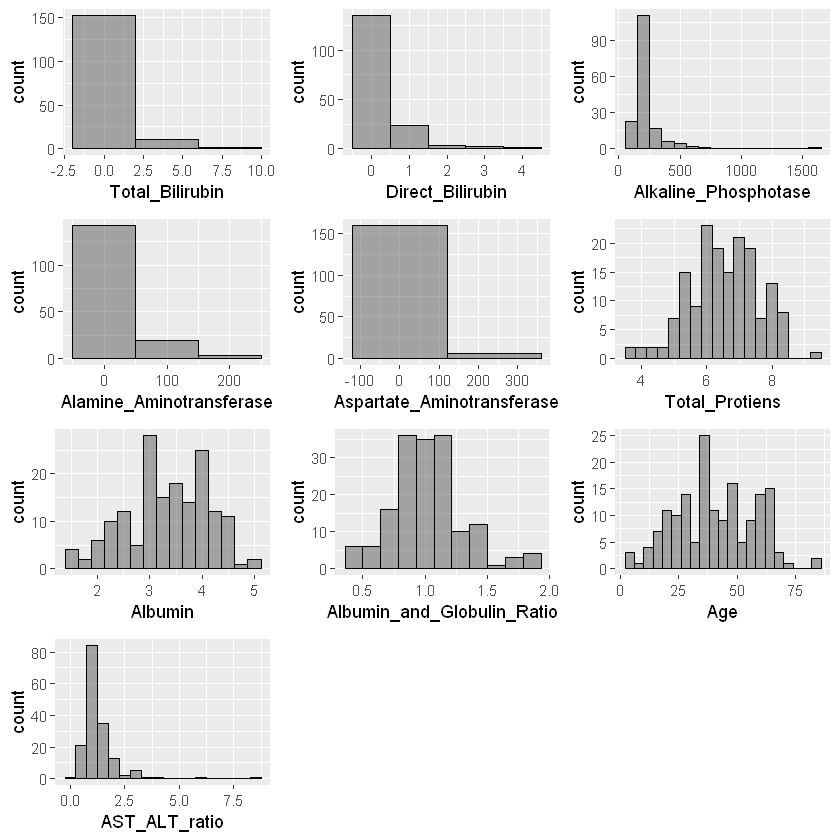

In [64]:
#generate some histgrams to get a sense of distribution 
#nondiseased
ph1 <- ggplot(df.nd, aes(x=Total_Bilirubin)) +
  geom_histogram(binwidth=4, colour="black", alpha=.5)
ph2 <- ggplot(df.nd, aes(x=Direct_Bilirubin)) +
  geom_histogram(binwidth=1, colour="black", alpha=.5)
ph3 <- ggplot(df.nd, aes(x=Alkaline_Phosphotase)) +
  geom_histogram(binwidth=100, colour="black", alpha=.5)
ph4 <- ggplot(df.nd, aes(x=Alamine_Aminotransferase)) +
  geom_histogram(binwidth=100, colour="black", alpha=.5)
ph5 <- ggplot(df.nd, aes(x=Aspartate_Aminotransferase)) +
  geom_histogram(binwidth=240, colour="black", alpha=.5)
ph6 <- ggplot(df.nd, aes(x=Total_Protiens)) +
  geom_histogram(binwidth=1/3, colour="black", alpha=.5)
ph7 <- ggplot(df.nd, aes(x=Albumin)) +
  geom_histogram(binwidth=1/4, colour="black", alpha=.5)
ph8 <- ggplot(df.nd, aes(x=Albumin_and_Globulin_Ratio)) +
  geom_histogram(binwidth=1/7, colour="black", alpha=.5)
ph9 <- ggplot(df.nd, aes(x=Age)) +
  geom_histogram(binwidth=4, colour="black", alpha=.5)
ph10 <- ggplot(df.nd, aes(x=AST_ALT_ratio)) +
  geom_histogram(binwidth=1/2, colour="black", alpha=.5)
grid.arrange(ph1, ph2, ph3, ph4, ph5, ph6, ph7, ph8, ph9, ph10, ncol=3)

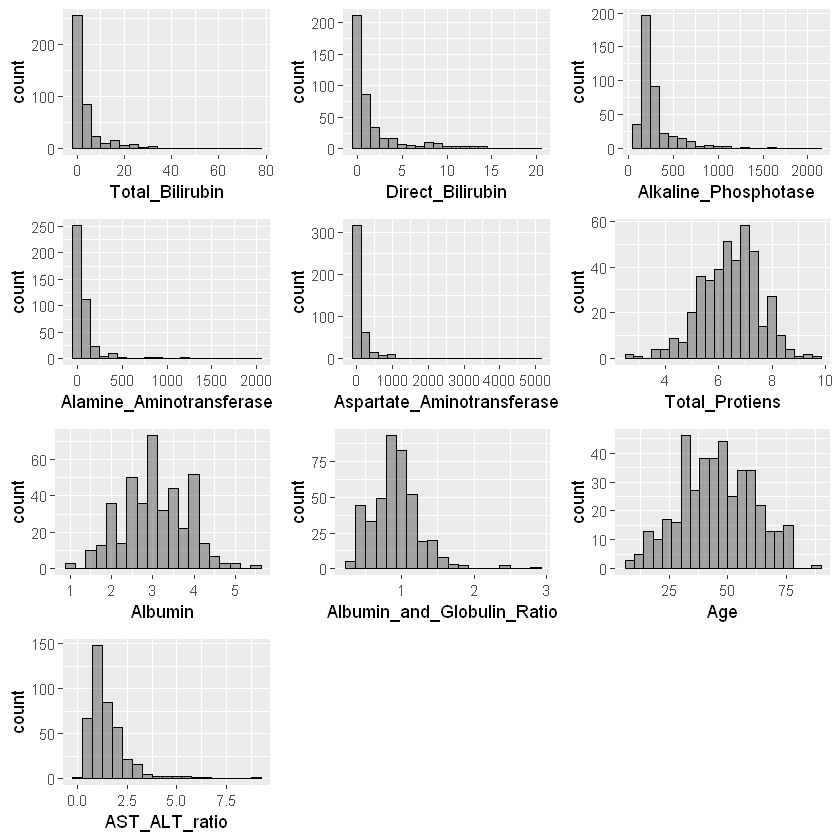

In [65]:
#Histogram diseased
ph1 <- ggplot(df.d, aes(x=Total_Bilirubin)) +
  geom_histogram(binwidth=4, colour="black", alpha=.5)
ph2 <- ggplot(df.d, aes(x=Direct_Bilirubin)) +
  geom_histogram(binwidth=1, colour="black", alpha=.5)
ph3 <- ggplot(df.d, aes(x=Alkaline_Phosphotase)) +
  geom_histogram(binwidth=100, colour="black", alpha=.5)
ph4 <- ggplot(df.d, aes(x=Alamine_Aminotransferase)) +
  geom_histogram(binwidth=100, colour="black", alpha=.5)
ph5 <- ggplot(df.d, aes(x=Aspartate_Aminotransferase)) +
  geom_histogram(binwidth=240, colour="black", alpha=.5)
ph6 <- ggplot(df.d, aes(x=Total_Protiens)) +
  geom_histogram(binwidth=1/3, colour="black", alpha=.5)
ph7 <- ggplot(df.d, aes(x=Albumin)) +
  geom_histogram(binwidth=1/4, colour="black", alpha=.5)
ph8 <- ggplot(df.d, aes(x=Albumin_and_Globulin_Ratio)) +
  geom_histogram(binwidth=1/7, colour="black", alpha=.5)
ph9 <- ggplot(df.d, aes(x=Age)) +
  geom_histogram(binwidth=4, colour="black", alpha=.5)
ph10 <- ggplot(df.d, aes(x=AST_ALT_ratio)) +
  geom_histogram(binwidth=1/2, colour="black", alpha=.5)
grid.arrange(ph1, ph2, ph3, ph4, ph5, ph6, ph7, ph8, ph9, ph10, ncol=3)

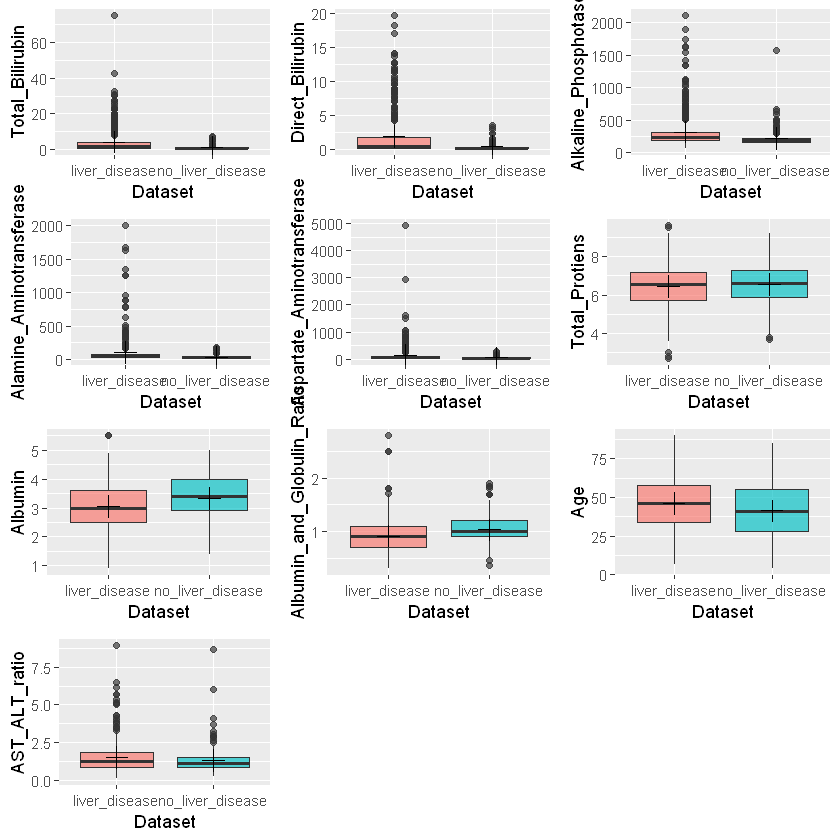

In [32]:
#Generate boxplots to get a sense of outliers & Skew 
pb1 <- ggplot(df.o, aes(Dataset, Total_Bilirubin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb2 <- ggplot(df.o, aes(Dataset, Direct_Bilirubin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb3 <- ggplot(df.o, aes(Dataset, Alkaline_Phosphotase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb4 <- ggplot(df.o, aes(Dataset, Alamine_Aminotransferase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb5 <- ggplot(df.o, aes(Dataset, Aspartate_Aminotransferase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb6 <- ggplot(df.o, aes(Dataset, Total_Protiens)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb7 <- ggplot(df.o, aes(Dataset, Albumin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb8 <- ggplot(df.o, aes(Dataset, Albumin_and_Globulin_Ratio)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb9 <- ggplot(df.o, aes(Dataset, Age)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb10 <- ggplot(df.o, aes(Dataset, AST_ALT_ratio)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
grid.arrange(pb1, pb2, pb3, pb4, pb5, pb6, pb7, pb8, pb9, pb10, ncol=3)

#some variables present as skewed, some with extreme values.

In [33]:
#Create log dataset to evaluate logistic distribution  This is warranted by the previouis box plots evidence
df.o.log <- df.o
df.o.log[,c("Total_Bilirubin", "Direct_Bilirubin", "Alkaline_Phosphotase", "Alamine_Aminotransferase", "Aspartate_Aminotransferase", "Albumin_and_Globulin_Ratio", "AST_ALT_ratio")] <- lapply(df.o.log[,c("Total_Bilirubin", "Direct_Bilirubin", "Alkaline_Phosphotase", "Alamine_Aminotransferase", "Aspartate_Aminotransferase", "Albumin_and_Globulin_Ratio", "AST_ALT_ratio")], function(x) (log(x+1)))

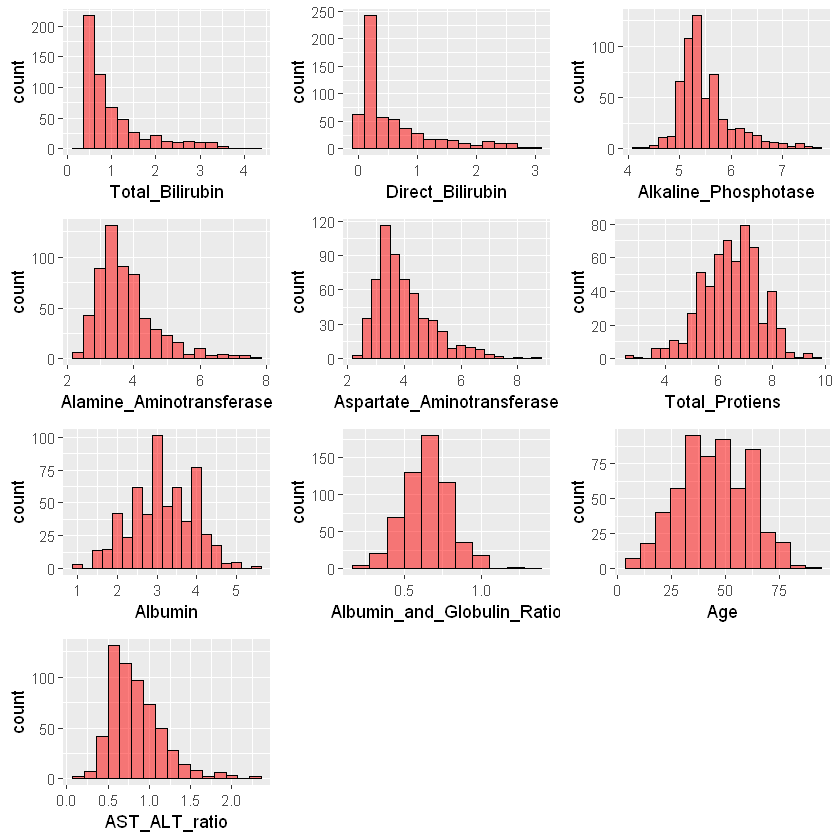

In [34]:
phh1 <- ggplot(df.o.log, aes(x=Total_Bilirubin)) +
  geom_histogram(binwidth=1/4, fill="red", colour="black", alpha=.5)

phh2 <- ggplot(df.o.log, aes(x=Direct_Bilirubin)) +
  geom_histogram(binwidth=1/5, fill="red", colour="black", alpha=.5)

phh3 <- ggplot(df.o.log, aes(x=Alkaline_Phosphotase)) +
  geom_histogram(binwidth=1/6, fill="red", colour="black", alpha=.5)

phh4 <- ggplot(df.o.log, aes(x=Alamine_Aminotransferase)) +
  geom_histogram(binwidth=1/3, fill="red", colour="black", alpha=.5)

phh5 <- ggplot(df.o.log, aes(x=Aspartate_Aminotransferase)) +
  geom_histogram(binwidth=1/3, fill="red", colour="black", alpha=.5)

phh6 <- ggplot(df.o.log, aes(x=Total_Protiens)) +
  geom_histogram(binwidth=1/3, fill="red", colour="black", alpha=.5)

phh7 <- ggplot(df.o.log, aes(x=Albumin)) +
  geom_histogram(binwidth=1/4, fill="red", colour="black", alpha=.5)

phh8 <- ggplot(df.o.log, aes(x=Albumin_and_Globulin_Ratio)) +
  geom_histogram(binwidth=1/9, fill="red", colour="black", alpha=.5)

phh9 <- ggplot(df.o.log, aes(x=Age)) +
  geom_histogram(binwidth=7, fill="red", colour="black", alpha=.5)

phh10 <- ggplot(df.o.log, aes(x=AST_ALT_ratio)) +
  geom_histogram(binwidth=1/7, fill="red", colour="black", alpha=.5)

grid.arrange(phh1, phh2, phh3, phh4, phh5, phh6, phh7, phh8, phh9, phh10, ncol=3)


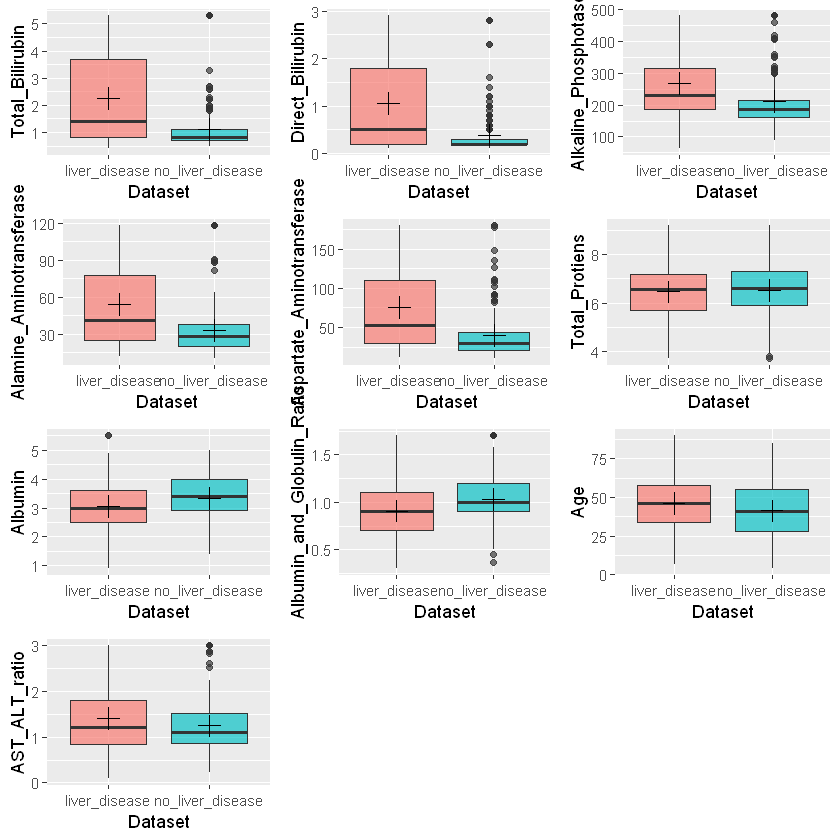

In [9]:
#gather extreme outliers
out1 <- sort.int(boxplot.stats(df.o$Total_Bilirubin)$out)
out2 <- sort.int(boxplot.stats(df.o$Direct_Bilirubin)$out)
out3 <- sort.int(boxplot.stats(df.o$Alkaline_Phosphotase)$out)
out4 <- sort.int(boxplot.stats(df.o$Alamine_Aminotransferase)$out)
out5 <- sort.int(boxplot.stats(df.o$Aspartate_Aminotransferase)$out)
out6 <- sort.int(boxplot.stats(df.o$Total_Protiens)$out)
out7 <- sort.int(boxplot.stats(df.o$Albumin)$out)
out8 <- sort.int(boxplot.stats(df.o$Albumin_and_Globulin_Ratio)$out)
out9 <- sort.int(boxplot.stats(df.o$Age)$out)
out10 <- sort.int(boxplot.stats(df.o$AST_ALT_ratio)$out)
#transform variables  
df.o.wo <- df.o %>%
  mutate(Total_Bilirubin = replace(Total_Bilirubin, Total_Bilirubin >= 5.5, 5.3),
         Direct_Bilirubin = replace(Direct_Bilirubin, Direct_Bilirubin >= 3, 2.8),
         Alkaline_Phosphotase = replace(Alkaline_Phosphotase, Alkaline_Phosphotase >= 482, 480),
         Alamine_Aminotransferase = replace(Alamine_Aminotransferase, Alamine_Aminotransferase >= 119, 118),
         Aspartate_Aminotransferase = replace(Aspartate_Aminotransferase, Aspartate_Aminotransferase >= 181, 180),
         Total_Protiens = replace(Total_Protiens, Total_Protiens >= 9.5, 9.2),
         Total_Protiens = replace(Total_Protiens, Total_Protiens <= 3.6, 3.7),
         Albumin_and_Globulin_Ratio = replace(Albumin_and_Globulin_Ratio, Albumin_and_Globulin_Ratio >= 1.72, 1.7),
         AST_ALT_ratio = replace(AST_ALT_ratio, AST_ALT_ratio >= 3.1, 3))
#plot
pb1 <- ggplot(df.o.wo, aes(Dataset, Total_Bilirubin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb2 <- ggplot(df.o.wo, aes(Dataset, Direct_Bilirubin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb3 <- ggplot(df.o.wo, aes(Dataset, Alkaline_Phosphotase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb4 <- ggplot(df.o.wo, aes(Dataset, Alamine_Aminotransferase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb5 <- ggplot(df.o.wo, aes(Dataset, Aspartate_Aminotransferase)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb6 <- ggplot(df.o.wo, aes(Dataset, Total_Protiens)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb7 <- ggplot(df.o.wo, aes(Dataset, Albumin)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb8 <- ggplot(df.o.wo, aes(Dataset, Albumin_and_Globulin_Ratio)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb9 <- ggplot(df.o.wo, aes(Dataset, Age)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
pb10 <- ggplot(df.o.wo, aes(Dataset, AST_ALT_ratio)) + geom_boxplot(aes(fill = Dataset), alpha = 2/3) + stat_summary(fun.y=mean, geom="point", shape=3, size=4) + theme(legend.position = "none")
grid.arrange(pb1, pb2, pb3, pb4, pb5, pb6, pb7, pb8, pb9, pb10, ncol=3)

[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

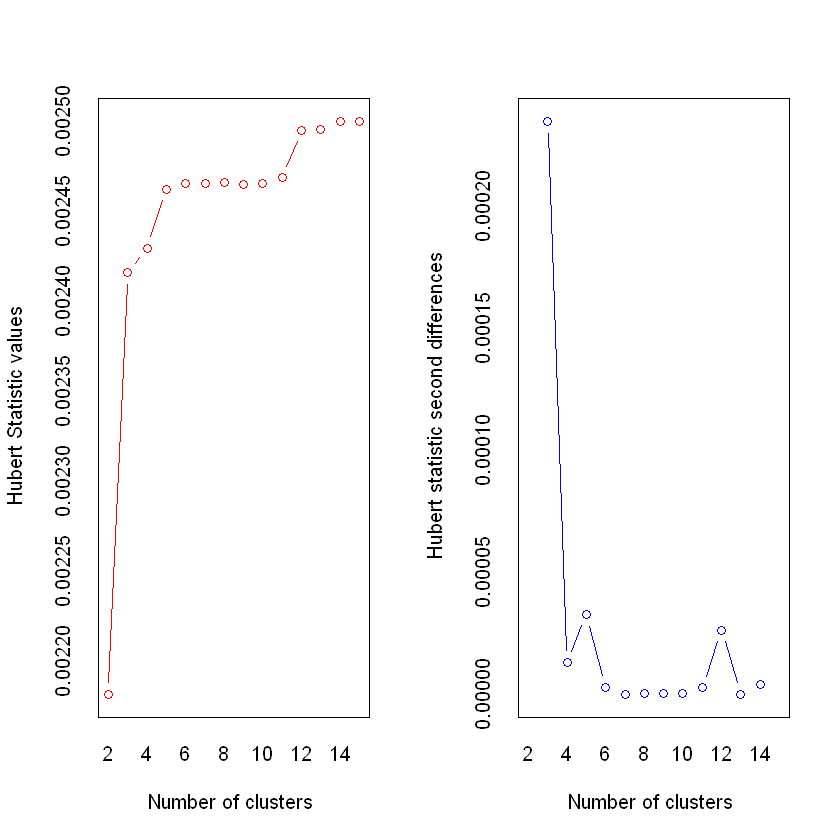

******************************************************************* 
* Among all indices:                                                
* 1 proposed 2 as the best number of clusters 
* 4 proposed 5 as the best number of clusters 
* 1 proposed 12 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  5 
 
 
******************************************************************* 
[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

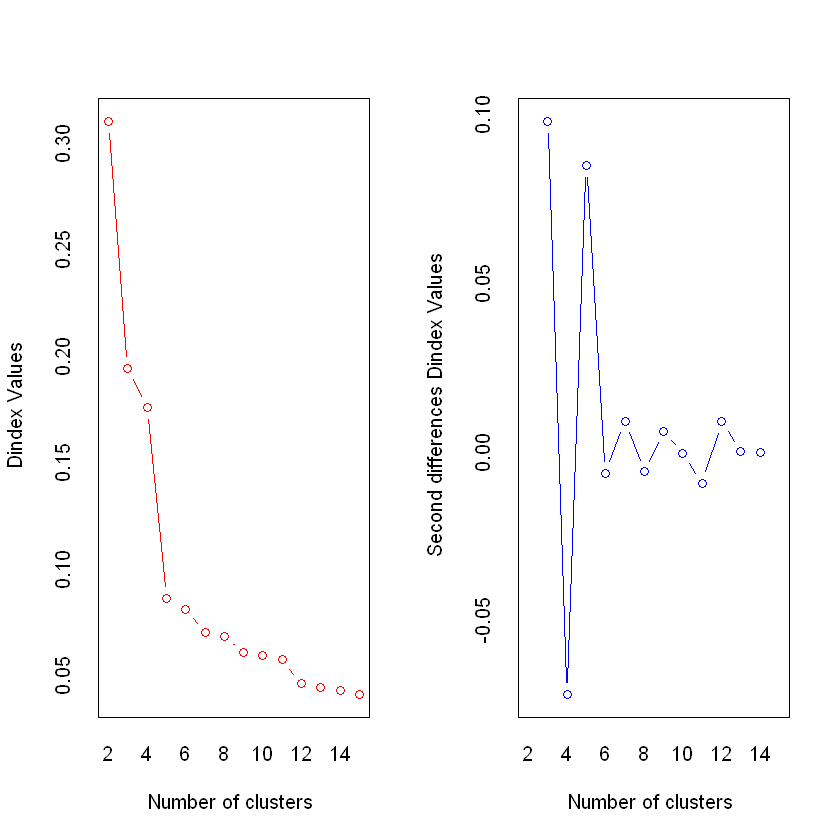

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

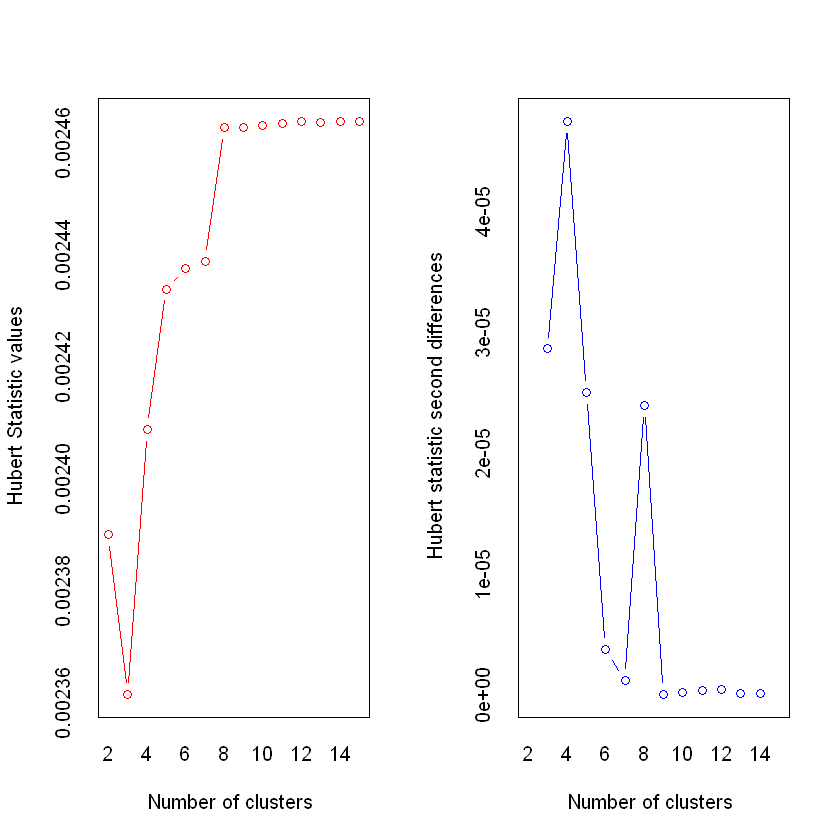

******************************************************************* 
* Among all indices:                                                
* 3 proposed 5 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 
* 1 proposed 9 as the best number of clusters 
* 1 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  5 
 
 
******************************************************************* 
[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

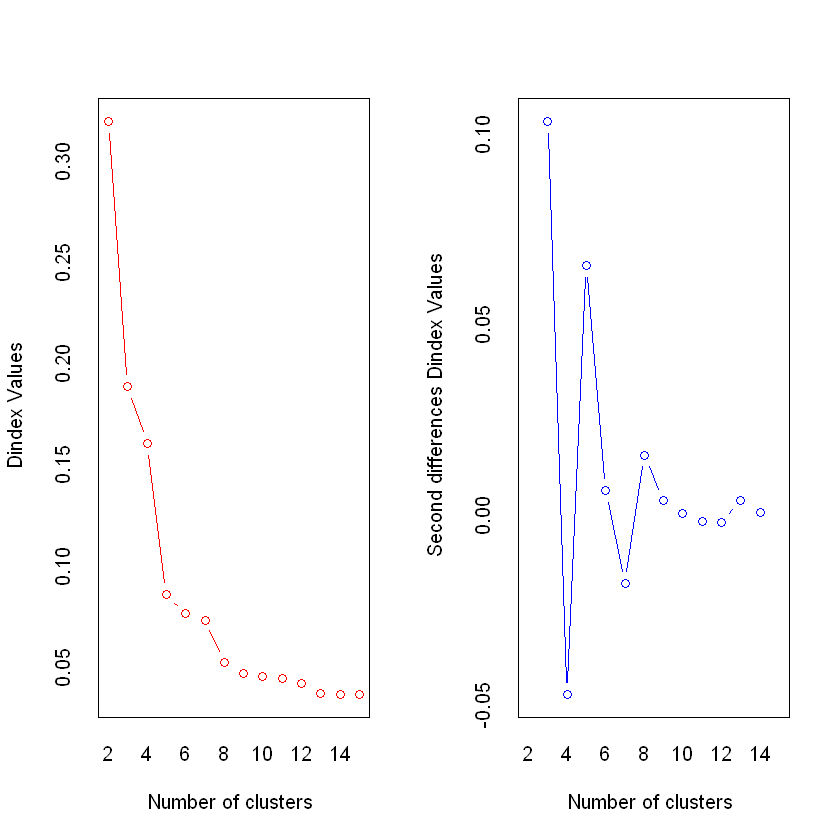

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

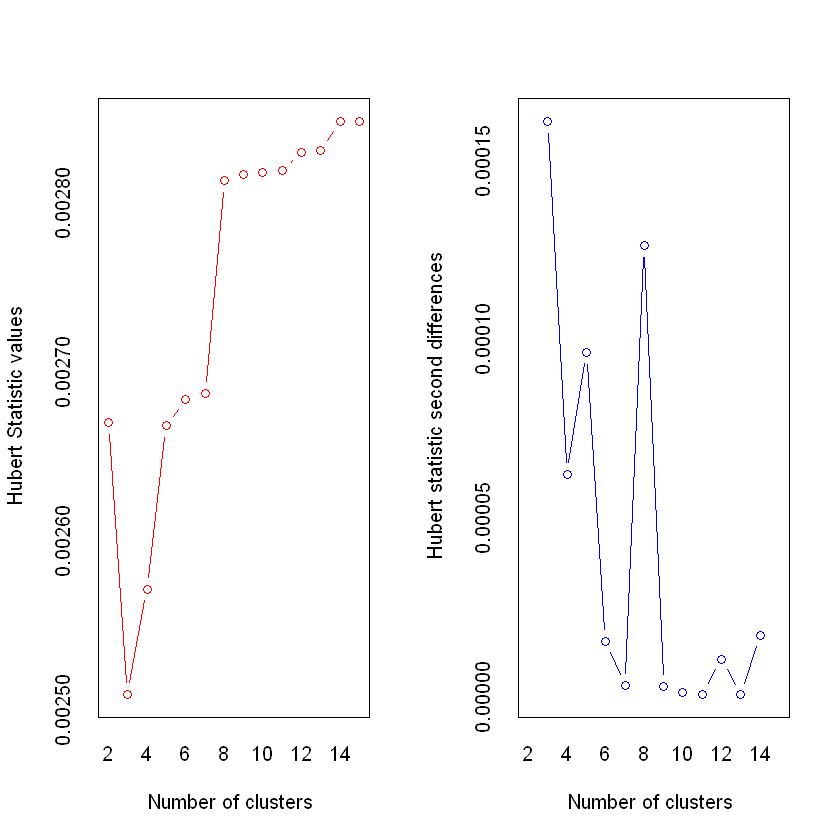

******************************************************************* 
* Among all indices:                                                
* 2 proposed 3 as the best number of clusters 
* 3 proposed 8 as the best number of clusters 
* 1 proposed 14 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  8 
 
 
******************************************************************* 
[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

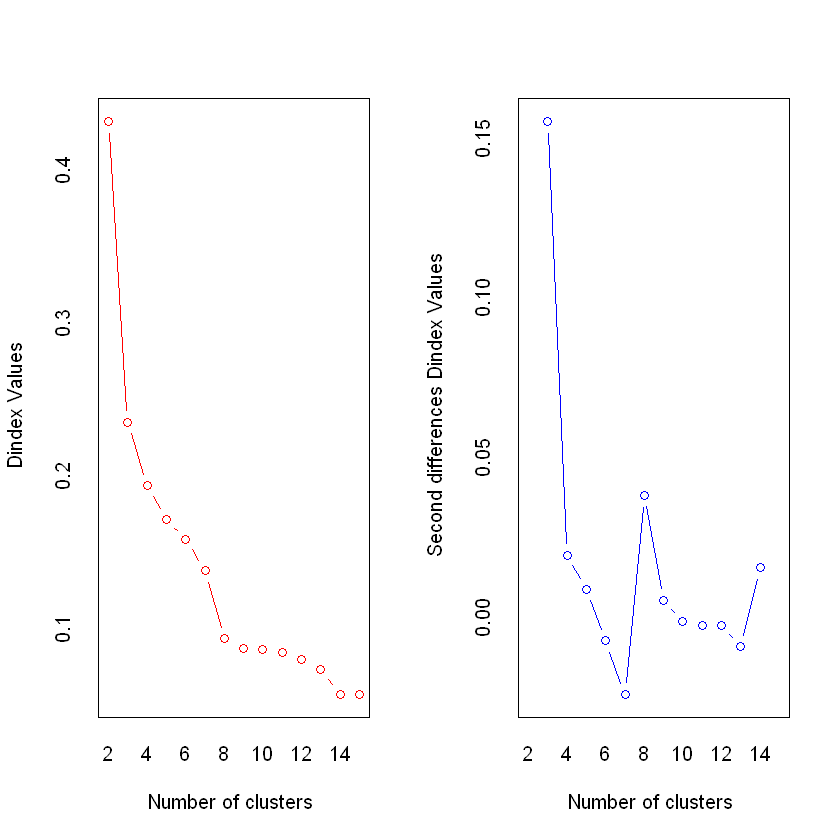

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

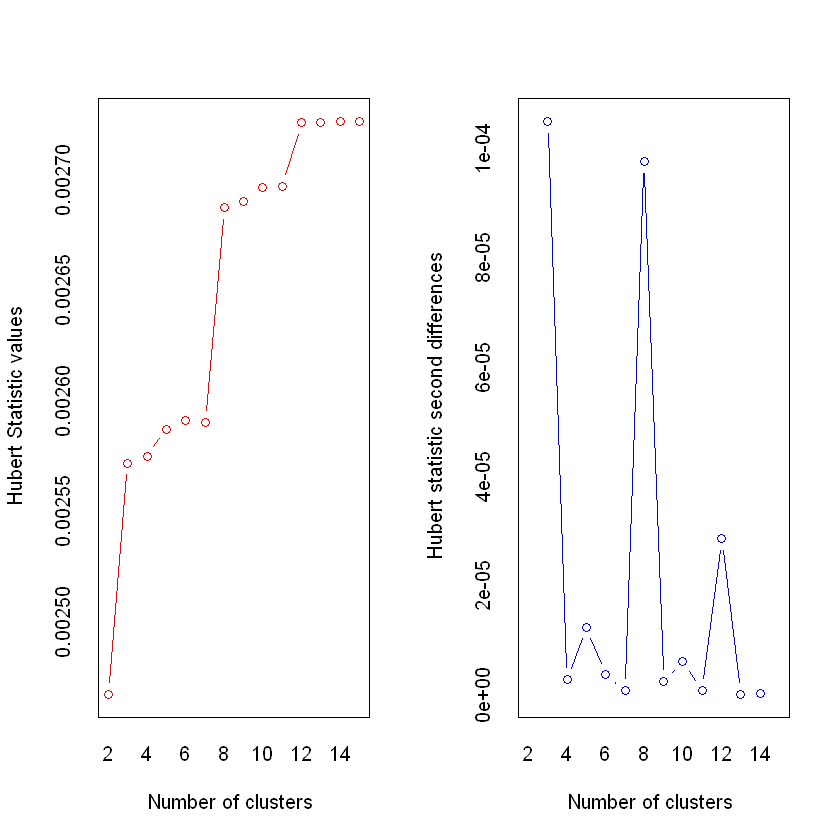

******************************************************************* 
* Among all indices:                                                
* 2 proposed 4 as the best number of clusters 
* 3 proposed 8 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  8 
 
 
******************************************************************* 
[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

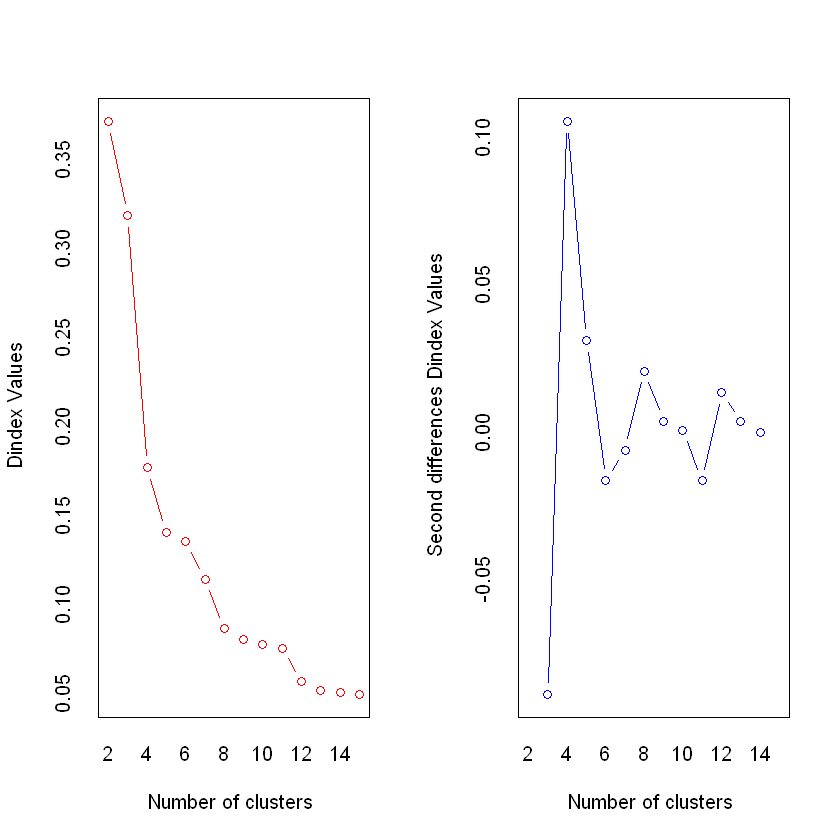

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

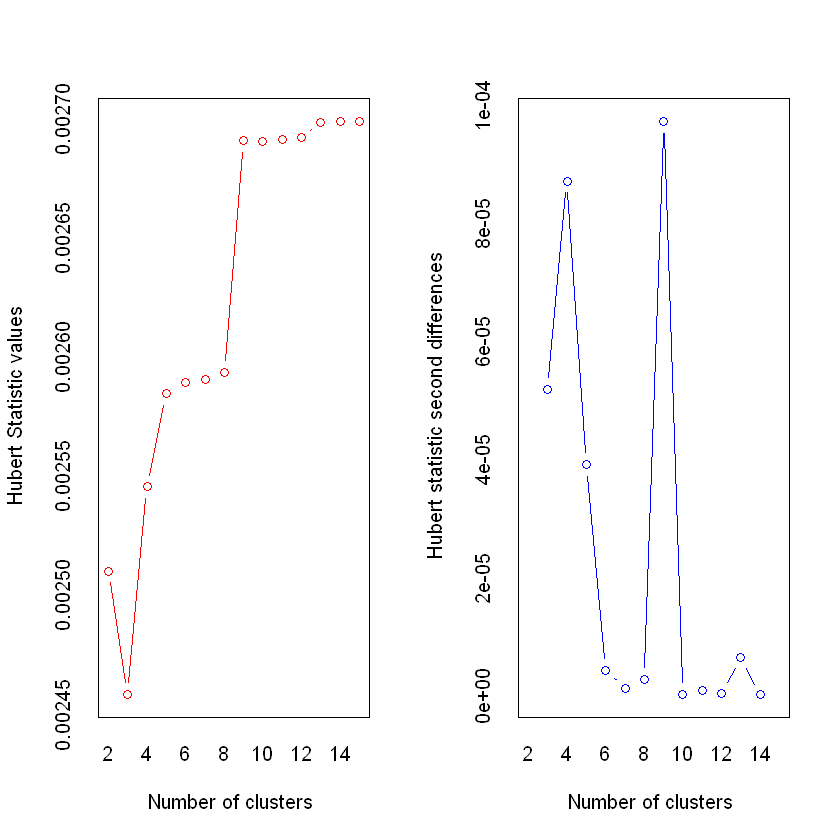

******************************************************************* 
* Among all indices:                                                
* 4 proposed 5 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 
* 1 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  5 
 
 
******************************************************************* 


Warning message in sqrt(zvargss$varbgss/zvargss$vartss):
"NaNs produced"Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

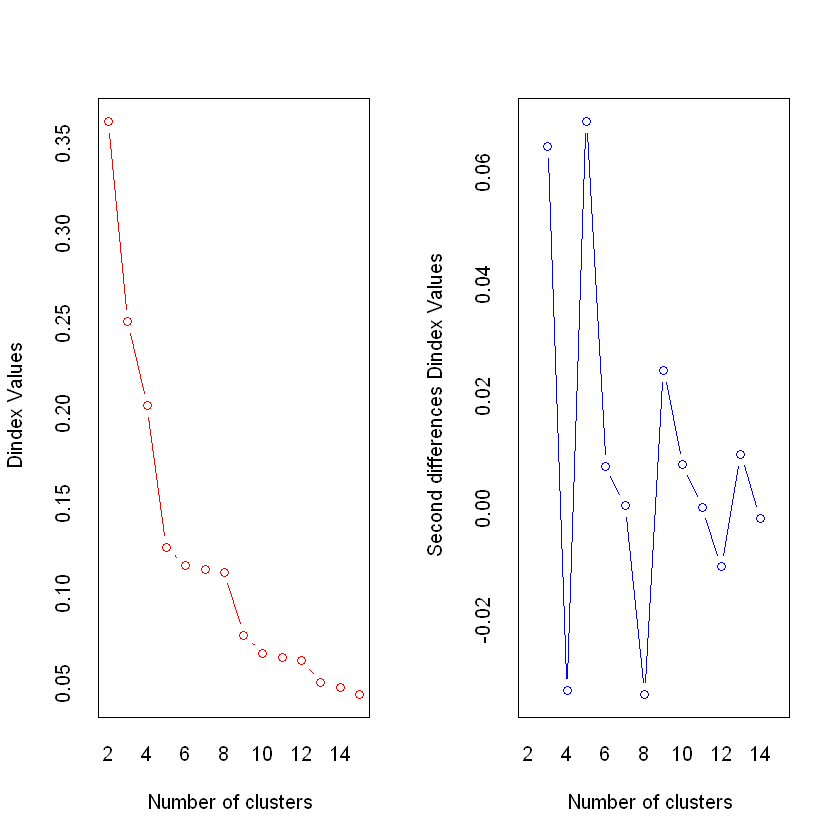

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

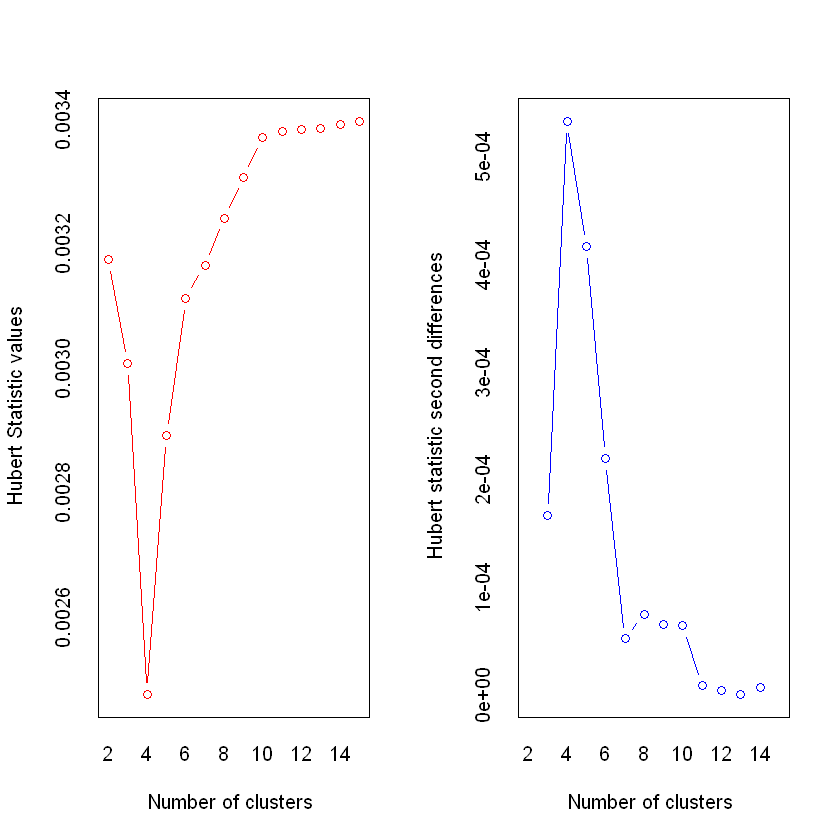

******************************************************************* 
* Among all indices:                                                
* 2 proposed 4 as the best number of clusters 
* 1 proposed 5 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 2 proposed 11 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  4 
 
 
******************************************************************* 


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

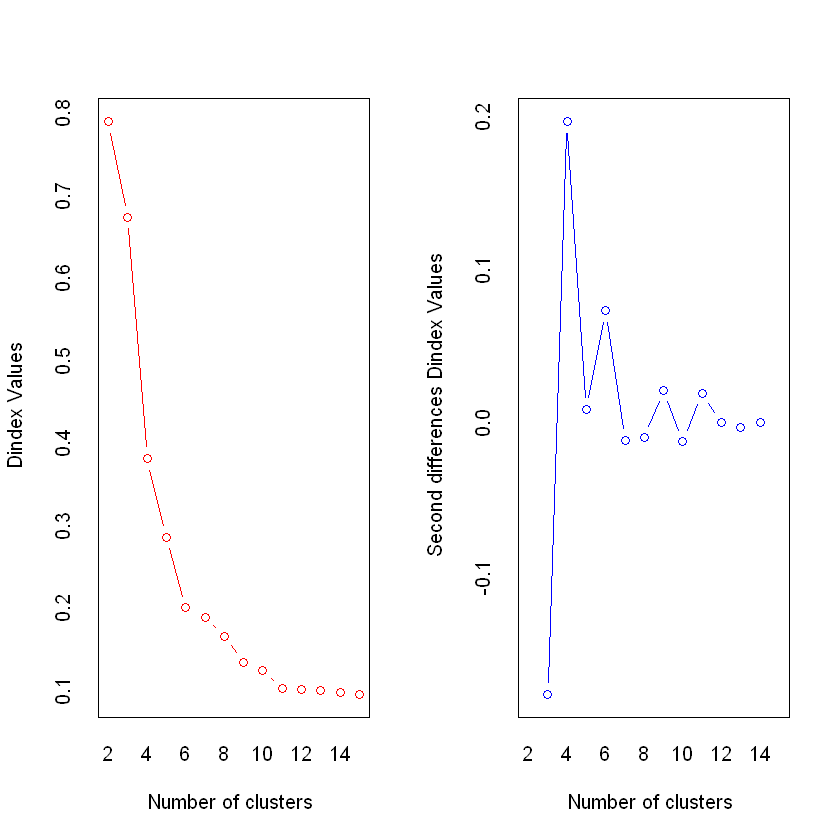

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

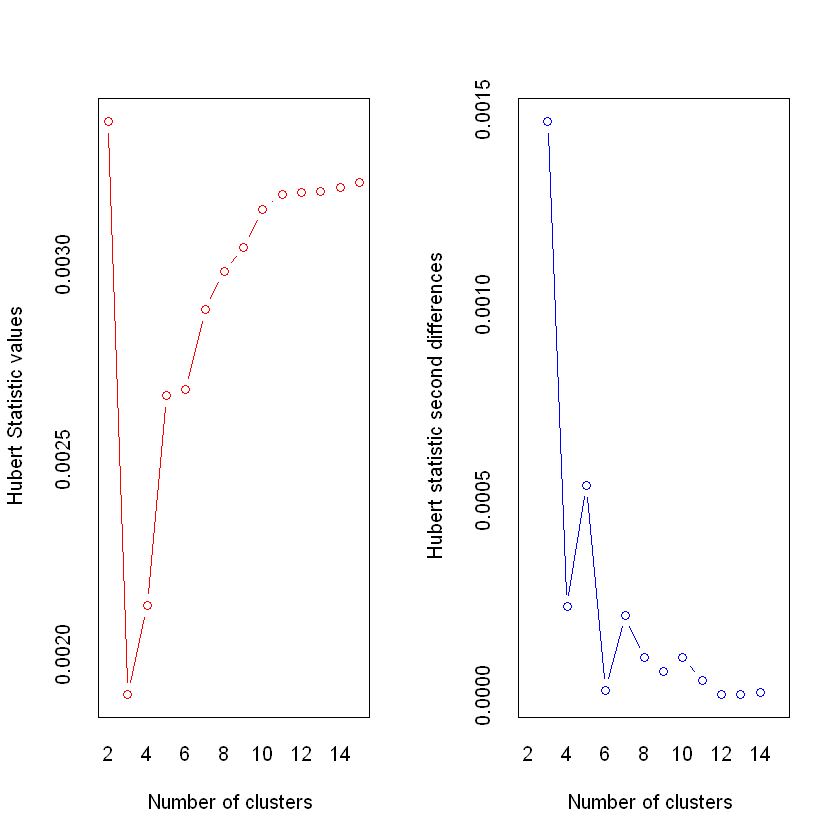

******************************************************************* 
* Among all indices:                                                
* 1 proposed 3 as the best number of clusters 
* 2 proposed 5 as the best number of clusters 
* 3 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  15 
 
 
******************************************************************* 


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

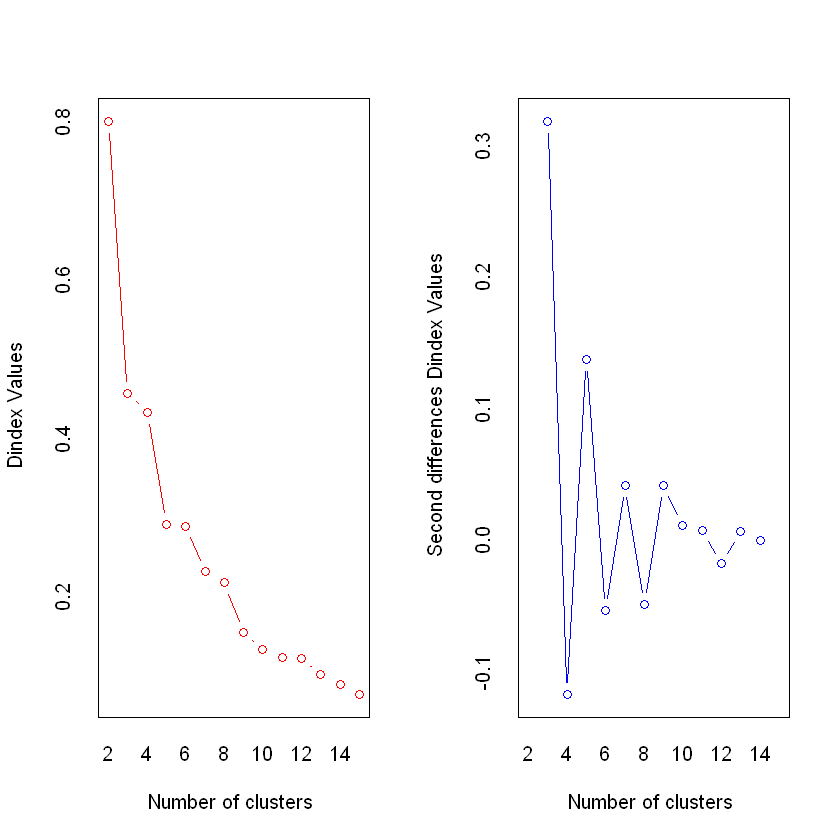

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

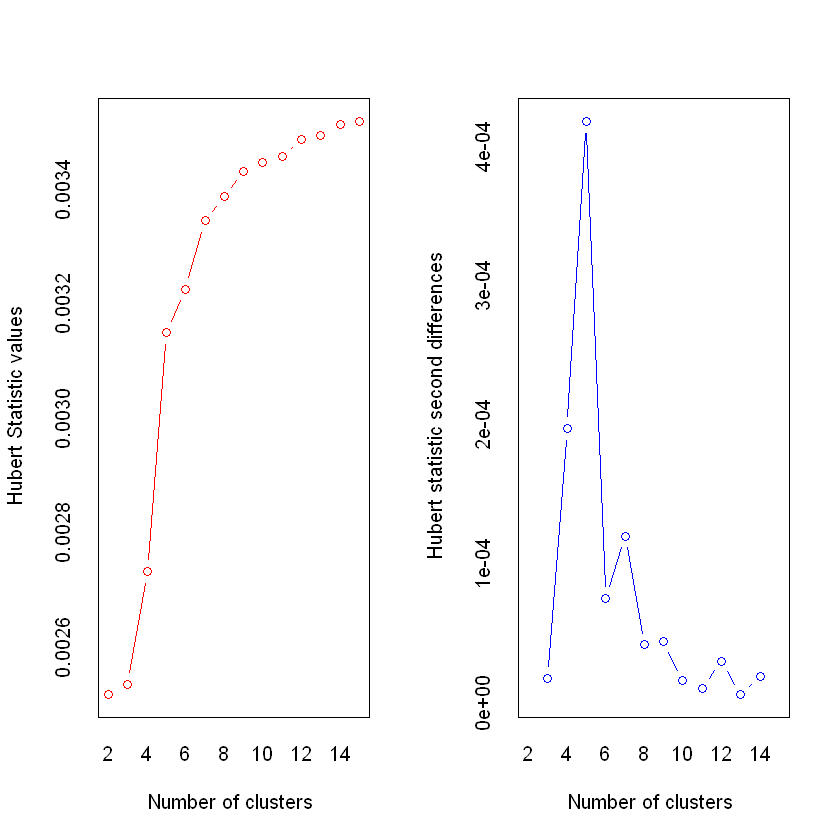

******************************************************************* 
* Among all indices:                                                
* 2 proposed 3 as the best number of clusters 
* 2 proposed 11 as the best number of clusters 
* 2 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
******************************************************************* 
[1] "Frey index : No clustering structure in this data set"


Warning message in max(DiffLev[, 5], na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

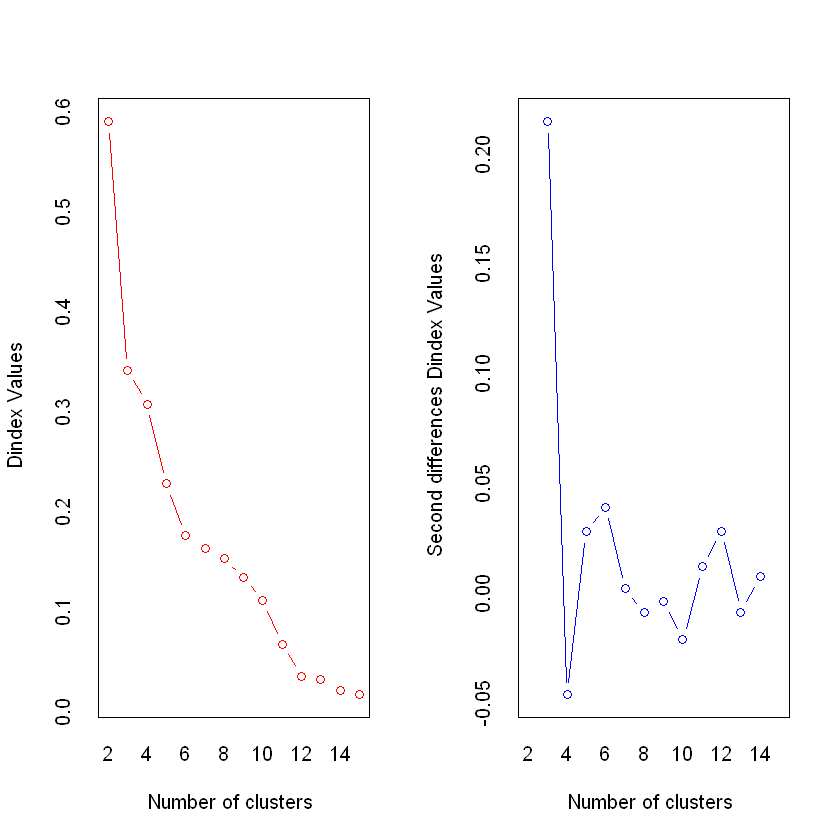

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
"data length [51] is not a sub-multiple or multiple of the number of rows [2]"

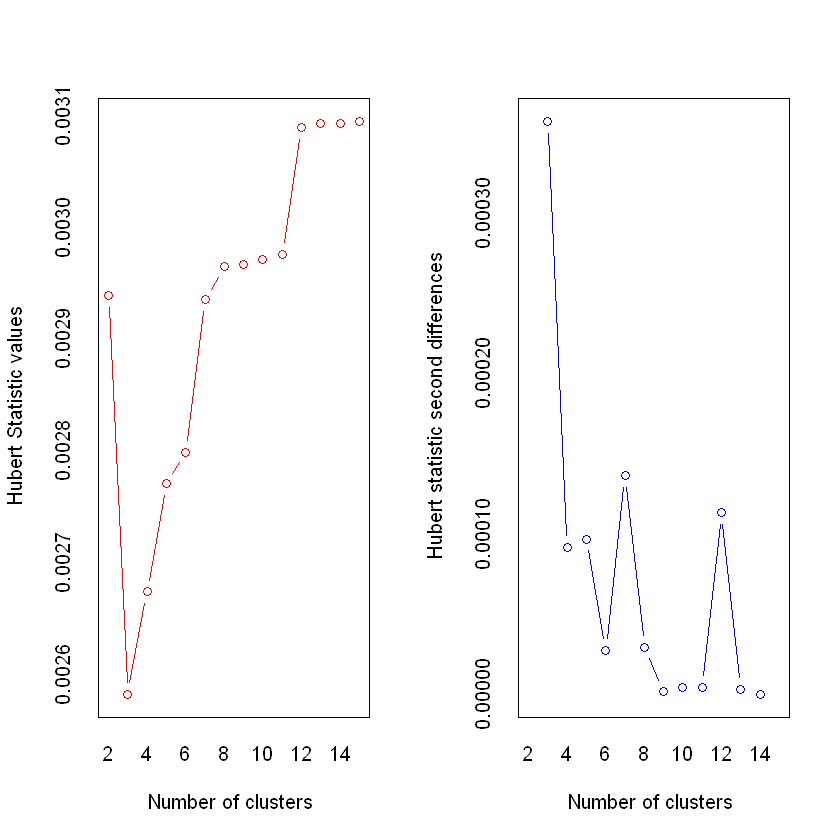

******************************************************************* 
* Among all indices:                                                
* 3 proposed 3 as the best number of clusters 
* 1 proposed 6 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
******************************************************************* 


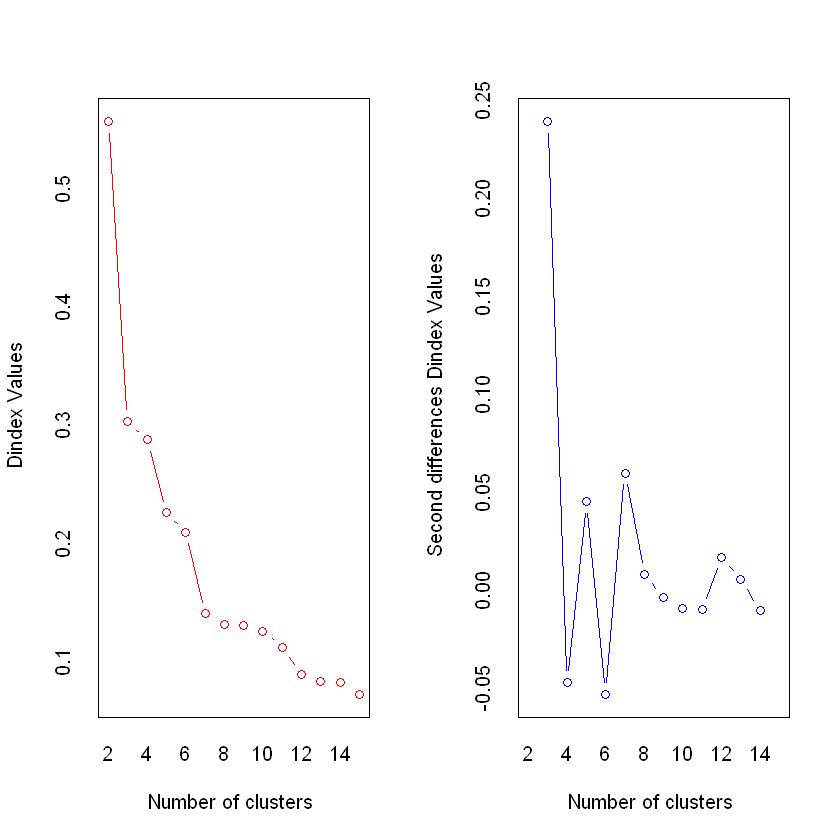

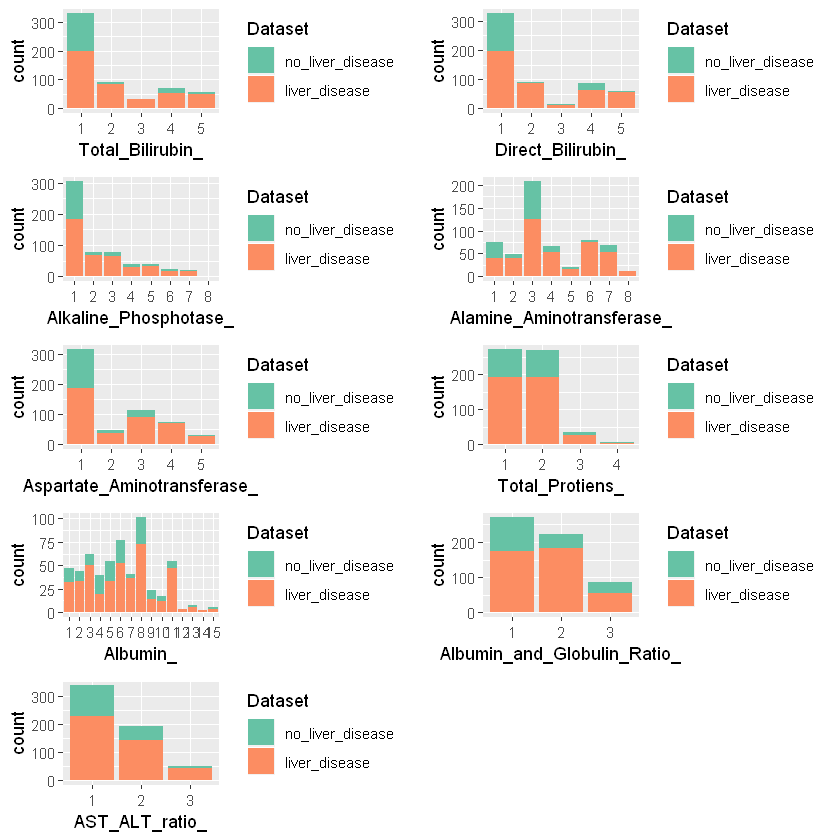

In [35]:
#Use NBClust to measure clustering of variables, particulary w/ euclidean difference
#euclidean may not always be best, but for purposes of this interview I feel good it will do fine
df.cat <- df.o.wo

d3 <- dist(df.cat[, 3])
d4 <- dist(df.cat[, 4])
d5 <- dist(df.cat[, 5])
d6 <- dist(df.cat[, 6])
d7 <- dist(df.cat[, 7])
d8 <- dist(df.cat[, 8])
d9 <- dist(df.cat[, 9])
d10 <- dist(df.cat[, 10])
d11 <- dist(df.cat[, 11])

nc3 <- NbClust(scale(df.cat[, 3]), distance="euclidean", min.nc=2, max.nc=15, method="average") #5
nc4 <- NbClust(scale(df.cat[, 4]), distance="euclidean", min.nc=2, max.nc=15, method="average") #5
nc5 <- NbClust(scale(df.cat[, 5]), distance="euclidean", min.nc=2, max.nc=15, method="average") #8
nc6 <- NbClust(scale(df.cat[, 6]), distance="euclidean", min.nc=2, max.nc=15, method="average") #8
nc7 <- NbClust(scale(df.cat[, 7]), distance="euclidean", min.nc=2, max.nc=15, method="average") #5
nc8 <- NbClust(scale(df.cat[, 8]), distance="euclidean", min.nc=2, max.nc=15, method="average") #4
nc9 <- NbClust(scale(df.cat[, 9]), distance="euclidean", min.nc=2, max.nc=15, method="average") #15
nc10 <- NbClust(scale(df.cat[, 10]), distance="euclidean", min.nc=2, max.nc=15, method="average") #3
nc11 <- NbClust(scale(df.cat[, 11]), distance="euclidean", min.nc=2, max.nc=15, method="average") #3

fit3 <- hclust(d3, method="average")
fit4 <- hclust(d4, method="average")
fit5 <- hclust(d5, method="average")
fit6 <- hclust(d6, method="average")
fit7 <- hclust(d7, method="average")
fit8 <- hclust(d8, method="average")
fit9 <- hclust(d9, method="average")
fit10 <- hclust(d10, method="average")
fit11 <- hclust(d11, method="average")

c3 <- cutree(fit3, k=5)
c4 <- cutree(fit4, k=5)
c5 <- cutree(fit5, k=8)
c6 <- cutree(fit6, k=8)
c7 <- cutree(fit7, k=5)
c8 <- cutree(fit8, k=4)
c9 <- cutree(fit9, k=15)
c10 <- cutree(fit10, k=3)
c11 <- cutree(fit11, k=3)

df.catfinal <- cbind(df.cat, c3, c4, c5, c6, c7, c8, c9, c10, c11)
df.catfinal2 <- subset(df.catfinal, select = c("Age", "Gender", "Total_Bilirubin", "c3", "Direct_Bilirubin", "c4", "Alkaline_Phosphotase", "c5", "Alamine_Aminotransferase", "c6", "Aspartate_Aminotransferase", "c7", "Total_Protiens", "c8", "Albumin", "c9", "Albumin_and_Globulin_Ratio", "c10", "AST_ALT_ratio", "c11","Dataset"))

df.catfinal2 <- df.catfinal2 %>%
  dplyr::rename(Total_Bilirubin_ = c3, Direct_Bilirubin_ = c4, Alkaline_Phosphotase_ = c5, Alamine_Aminotransferase_ = c6, Aspartate_Aminotransferase_ = c7, Total_Protiens_ = c8, Albumin_ = c9, Albumin_and_Globulin_Ratio_ = c10, AST_ALT_ratio_ = c11)

df.cat.f <- subset(df.catfinal2, select = c("Age", "Gender", "Total_Bilirubin_", "Direct_Bilirubin_", "Alkaline_Phosphotase_", "Alamine_Aminotransferase_", "Aspartate_Aminotransferase_", "Total_Protiens_", "Albumin_", "Albumin_and_Globulin_Ratio_", "AST_ALT_ratio_", "Dataset"))

df.cat.f$Total_Bilirubin_ <- as.factor(df.cat.f$Total_Bilirubin_)
df.cat.f$Direct_Bilirubin_ <- as.factor(df.cat.f$Direct_Bilirubin_)
df.cat.f$Alkaline_Phosphotase_ <- as.factor(df.cat.f$Alkaline_Phosphotase_)
df.cat.f$Alamine_Aminotransferase_ <- as.factor(df.cat.f$Alamine_Aminotransferase_)
df.cat.f$Aspartate_Aminotransferase_ <- as.factor(df.cat.f$Aspartate_Aminotransferase_)
df.cat.f$Total_Protiens_ <- as.factor(df.cat.f$Total_Protiens_)
df.cat.f$Albumin_ <- as.factor(df.cat.f$Albumin_)
df.cat.f$Albumin_and_Globulin_Ratio_ <- as.factor(df.cat.f$Albumin_and_Globulin_Ratio_)
df.cat.f$AST_ALT_ratio_ <- as.factor(df.cat.f$AST_ALT_ratio_)

p1 <- ggplot(df.cat.f, aes(x=Total_Bilirubin_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p2 <- ggplot(df.cat.f, aes(x=Direct_Bilirubin_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p3 <- ggplot(df.cat.f, aes(x=Alkaline_Phosphotase_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p4 <- ggplot(df.cat.f, aes(x=Alamine_Aminotransferase_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p5 <- ggplot(df.cat.f, aes(x=Aspartate_Aminotransferase_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p6 <- ggplot(df.cat.f, aes(x=Total_Protiens_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p7 <- ggplot(df.cat.f, aes(x=Albumin_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p8 <- ggplot(df.cat.f, aes(x=Albumin_and_Globulin_Ratio_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

p9 <- ggplot(df.cat.f, aes(x=AST_ALT_ratio_)) + 
  geom_bar(aes(fill=Dataset)) +
  scale_fill_brewer(palette = "Set2")

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=2)



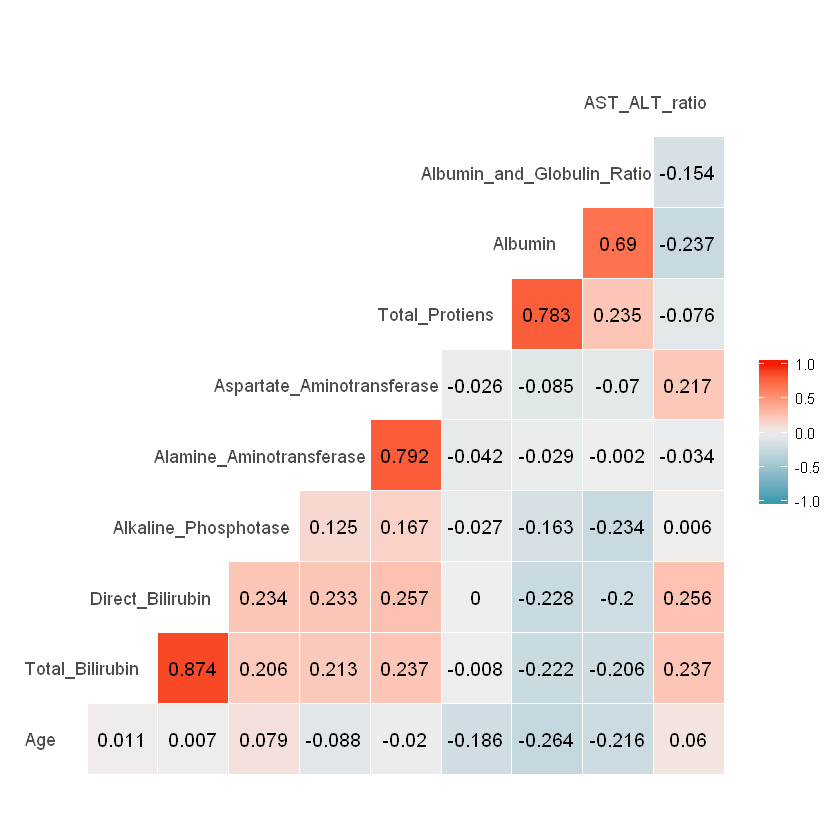

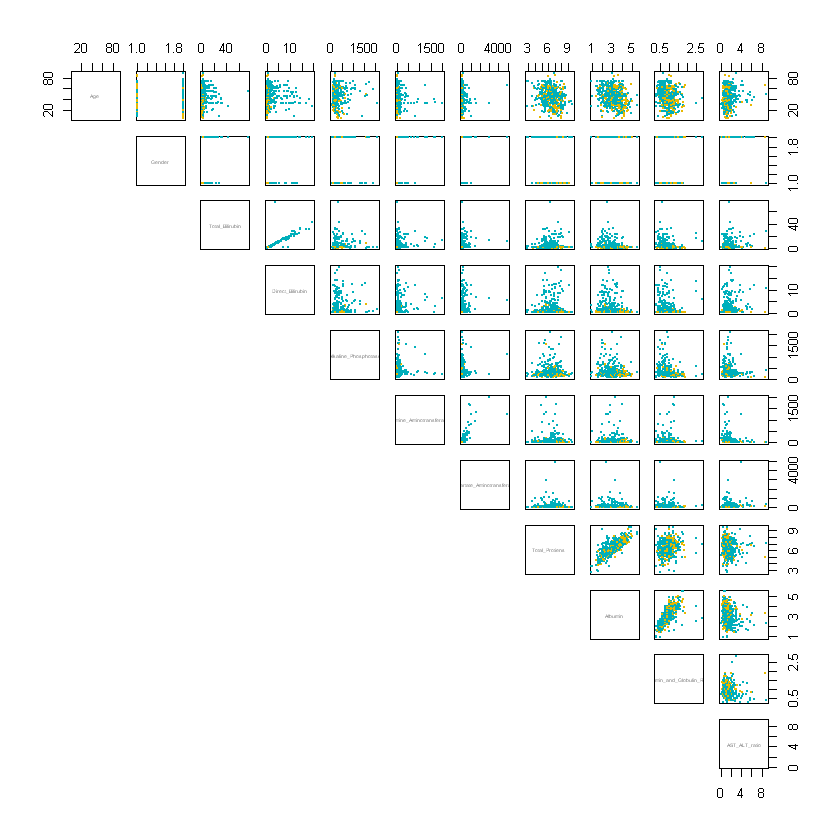

In [36]:
#Variable Correlation 
ggcorr(subset(df.o, select = -c(Gender, Dataset)), palette = "RdBu", label = TRUE, label_round = 3, color = "grey30",  hjust = 0.85)
cols <- c("#00AFBB", "#E7B800")  
pairs(df.o[,1:11], pch = 19,  cex = 0.4,
      col = cols[df.o$Dataset],
      lower.panel=NULL,
      cex.labels = 0.4)

In [71]:
#wilcox text of the datasets as data is not normally distriduted, test methods are limited
wilcox.tests.o <- lapply(df.o[,c("Total_Bilirubin", "Direct_Bilirubin", "Alkaline_Phosphotase", "Alamine_Aminotransferase", "Aspartate_Aminotransferase", "Total_Protiens", "Albumin", "Albumin_and_Globulin_Ratio", "Age", "AST_ALT_ratio")], function(x) wilcox.test(x ~ df.o$Dataset)$p.value)
wilcox.tests.o.log <- lapply(df.o.log[,c("Total_Bilirubin", "Direct_Bilirubin", "Alkaline_Phosphotase", "Alamine_Aminotransferase", "Aspartate_Aminotransferase", "Total_Protiens", "Albumin", "Albumin_and_Globulin_Ratio", "Age", "AST_ALT_ratio")], function(x) wilcox.test(x ~ df.o.log$Dataset)$p.value)
wilcox.tests.o.wo <- lapply(df.o.wo[,c("Total_Bilirubin", "Direct_Bilirubin", "Alkaline_Phosphotase", "Alamine_Aminotransferase", "Aspartate_Aminotransferase", "Total_Protiens", "Albumin", "Albumin_and_Globulin_Ratio", "Age", "AST_ALT_ratio")], function(x) wilcox.test(x ~ df.o.wo$Dataset)$p.value)
results_wilcox <- cbind(wilcox.tests.o, wilcox.tests.o.log, wilcox.tests.o.wo)

Warning message in chisq.test(xtabs(~Dataset + x, df.cat.f)):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(xtabs(~Dataset + x, df.cat.f)):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(xtabs(~Dataset + x, df.cat.f)):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(xtabs(~Dataset + x, df.cat.f)):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(xtabs(~Dataset + x, df.cat.f)):
"Chi-squared approximation may be incorrect"

$Gender
[1] 0.06432014

$Total_Bilirubin_
[1] 4.65473e-12

$Direct_Bilirubin_
[1] 1.482585e-12

$Alkaline_Phosphotase_
[1] 2.575551e-07

$Alamine_Aminotransferase_
[1] 2.234549e-09

$Aspartate_Aminotransferase_
[1] 3.965019e-11

$Total_Protiens_
[1] 0.8337877

$Albumin_
[1] 0.001863017

$Albumin_and_Globulin_Ratio_
[1] 3.908695e-05

$AST_ALT_ratio_
[1] 0.05498922

                  Total_Bilirubin_
Dataset                     1          2          3          4          5
  no_liver_disease  3.8463617 -4.0770597 -2.7405257 -0.2122961 -1.7972552
  liver_disease    -2.4282417  2.5738834  1.7301178  0.1340244  1.1346229

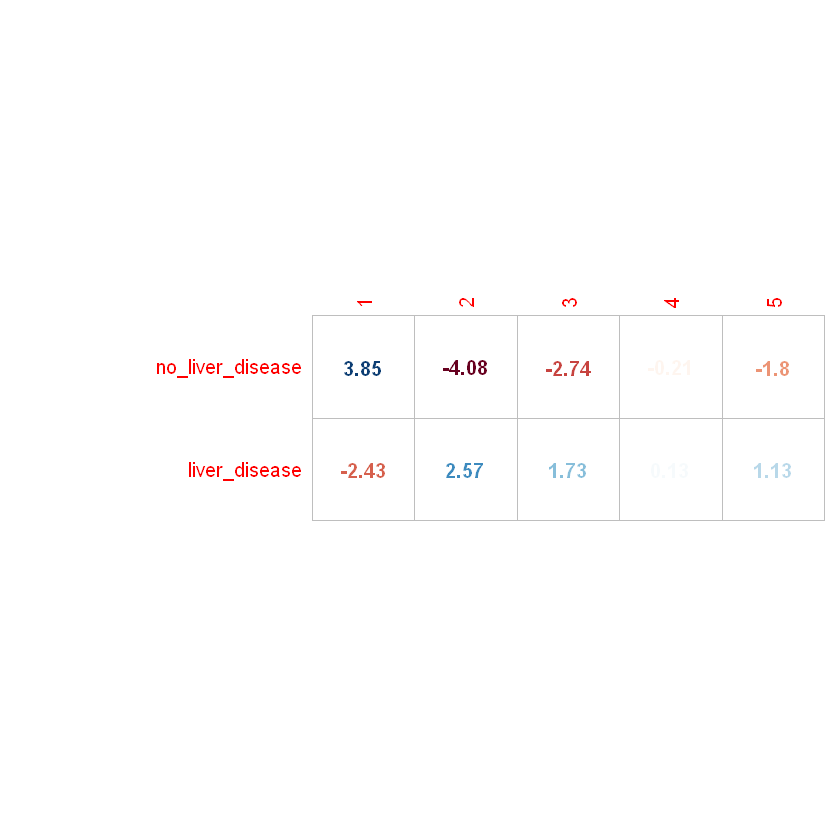

In [38]:
#chisqtests
chisq.tests <- lapply(df.cat.f[,c("Gender", "Total_Bilirubin_", "Direct_Bilirubin_", "Alkaline_Phosphotase_", "Alamine_Aminotransferase_", "Aspartate_Aminotransferase_", "Total_Protiens_", "Albumin_", "Albumin_and_Globulin_Ratio_", "AST_ALT_ratio_")], function(x) chisq.test(xtabs(~ Dataset + x, df.cat.f))$p.value)
chisq.tests
chisq.tests.ind <- chisq.test(xtabs(~ Dataset + Total_Bilirubin_, df.cat.f))
chisq.tests.ind$residuals
corrplot(chisq.tests.ind$residuals, is.cor = FALSE, method="number",  cl.pos = "n")

Age                     Gender 
                 Confirmed                   Rejected 
           Total_Bilirubin           Direct_Bilirubin 
                 Confirmed                  Confirmed 
      Alkaline_Phosphotase   Alamine_Aminotransferase 
                 Confirmed                  Confirmed 
Aspartate_Aminotransferase             Total_Protiens 
                 Confirmed                   Rejected 
                   Albumin Albumin_and_Globulin_Ratio 
                  Rejected                   Rejected 
             AST_ALT_ratio 
                  Rejected 
Levels: Tentative Confirmed Rejected

Age                     Gender 
                 Confirmed                   Rejected 
           Total_Bilirubin           Direct_Bilirubin 
                 Confirmed                  Confirmed 
      Alkaline_Phosphotase   Alamine_Aminotransferase 
                 Confirmed                  Confirmed 
Aspartate_Aminotransferase             Total_Protiens 
                 Confirmed                   Rejected 
                   Albumin Albumin_and_Globulin_Ratio 
                  Rejected                   Rejected 
             AST_ALT_ratio 
                  Rejected 
Levels: Tentative Confirmed Rejected

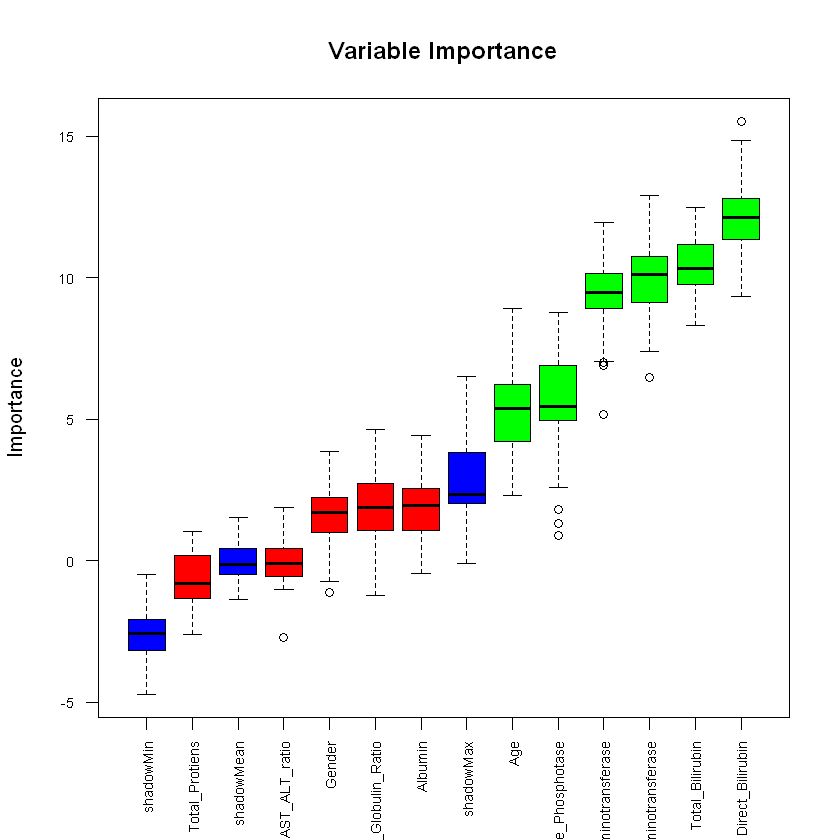

Age                      Gender 
                  Confirmed                   Tentative 
           Total_Bilirubin_           Direct_Bilirubin_ 
                  Confirmed                   Confirmed 
      Alkaline_Phosphotase_   Alamine_Aminotransferase_ 
                  Confirmed                   Confirmed 
Aspartate_Aminotransferase_             Total_Protiens_ 
                  Confirmed                    Rejected 
                   Albumin_ Albumin_and_Globulin_Ratio_ 
                   Rejected                    Rejected 
             AST_ALT_ratio_ 
                   Rejected 
Levels: Tentative Confirmed Rejected

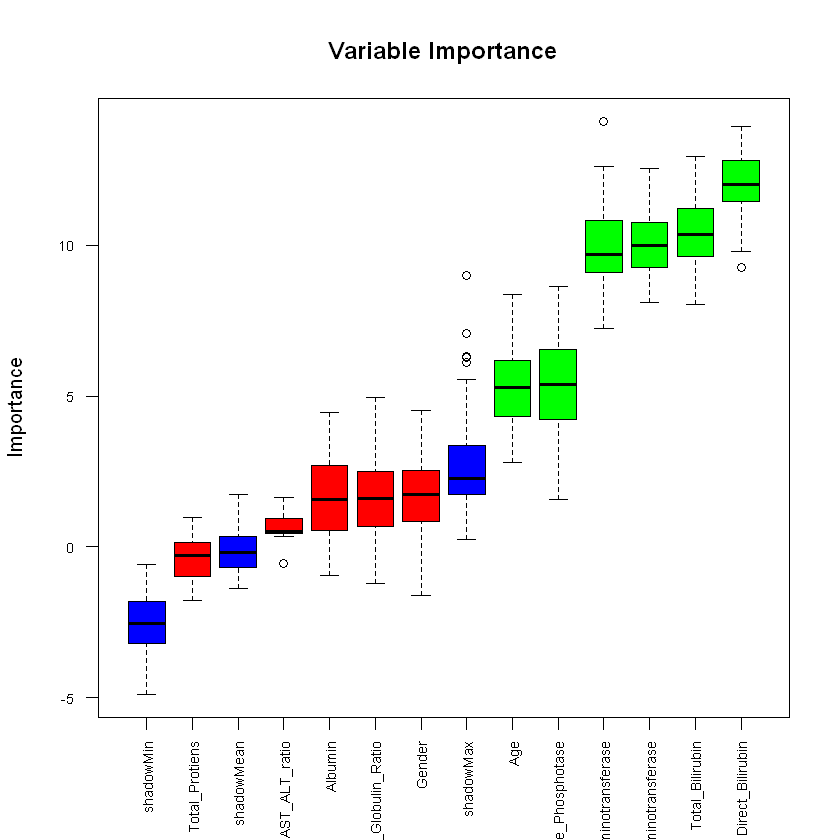

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Dataset ~ ., family = binomial(link = "logit"), 
    data = df.o)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4443  -0.8986  -0.3699   1.0723   3.2976  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                 3.4080440  1.3364579   2.550  0.01077 * 
Age                        -0.0183287  0.0063879  -2.869  0.00411 **
GenderMale                 -0.0298962  0.2334396  -0.128  0.89810   
Total_Bilirubin            -0.0088230  0.0827364  -0.107  0.91507   
Direct_Bilirubin           -0.4685817  0.2388022  -1.962  0.04974 * 
Alkaline_Phosphotase       -0.0012776  0.0008175  -1.563  0.11811   
Alamine_Aminotransferase   -0.0060124  0.0062308  -0.965  0.33457   
Aspartate_Aminotransferase -0.0076101  0.0050455  -1.508  0.13148   
Total_Protiens             -1.0023827  0.3862528  -2.595  0.00946 **
Albumin                     1.8699162  0.7609616   2.457  0.01400 * 
Albumin_and_Globulin_Rati

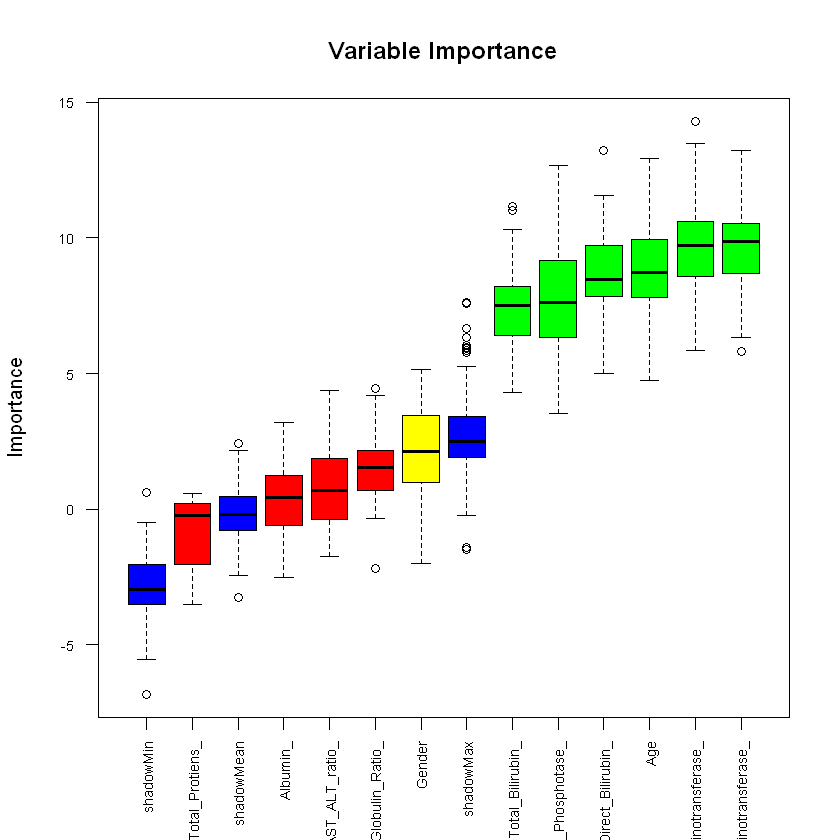

In [39]:
#Burota Variable Importance
boruta_output <- Boruta(Dataset ~ ., data=df.o, doTrace=0) 
boruta_output$finalDecision
plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")


boruta_output <- Boruta(Dataset ~ ., data=df.o.wo, doTrace=0) 
boruta_output$finalDecision
plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")


boruta_output <- Boruta(Dataset ~ ., data=df.cat.f, doTrace=0) 
boruta_output$finalDecision
plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")

model.lr <- glm(Dataset ~ ., data = df.o, family = binomial(link='logit'))
summary(model.lr)

In [40]:
#random forest importantce
fit=randomForest(Dataset~., data=df.o)
varImp(fit)
fit=randomForest(Dataset~., data=df.o.wo)
varImp(fit)
fit=randomForest(Dataset~., data=df.cat.f)
varImp(fit)

,Overall
Age,26.971605
Gender,3.405461
Total_Bilirubin,22.360521
Direct_Bilirubin,18.089335
Alkaline_Phosphotase,32.627306
Alamine_Aminotransferase,26.214069
Aspartate_Aminotransferase,27.116701
Total_Protiens,18.354880
Albumin,18.865647
Albumin_and_Globulin_Ratio,16.528592


,Overall
Age,27.323474
Gender,3.634285
Total_Bilirubin,22.279511
Direct_Bilirubin,17.492638
Alkaline_Phosphotase,30.275305
Alamine_Aminotransferase,27.478119
Aspartate_Aminotransferase,28.122796
Total_Protiens,19.102306
Albumin,18.849120
Albumin_and_Globulin_Ratio,16.098986


,Overall
Age,46.105749
Gender,7.198176
Total_Bilirubin_,13.243565
Direct_Bilirubin_,15.242275
Alkaline_Phosphotase_,21.697335
Alamine_Aminotransferase_,27.992751
Aspartate_Aminotransferase_,14.020286
Total_Protiens_,8.058790
Albumin_,39.176649
Albumin_and_Globulin_Ratio_,9.605267


In [41]:
#Regression method
model.lr <- glm(Dataset ~ ., data = df.o, family = binomial(link='logit'))
summary(model.lr)
#relevels
df.o$Dataset <- relevel(df.o$Dataset, "no_liver_disease")
df.o.wo$Dataset <- relevel(df.o.wo$Dataset, "no_liver_disease")
df.cat.f$Dataset <- relevel(df.cat.f$Dataset, "no_liver_disease")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Dataset ~ ., family = binomial(link = "logit"), 
    data = df.o)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4443  -0.8986  -0.3699   1.0723   3.2976  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                 3.4080440  1.3364579   2.550  0.01077 * 
Age                        -0.0183287  0.0063879  -2.869  0.00411 **
GenderMale                 -0.0298962  0.2334396  -0.128  0.89810   
Total_Bilirubin            -0.0088230  0.0827364  -0.107  0.91507   
Direct_Bilirubin           -0.4685817  0.2388022  -1.962  0.04974 * 
Alkaline_Phosphotase       -0.0012776  0.0008175  -1.563  0.11811   
Alamine_Aminotransferase   -0.0060124  0.0062308  -0.965  0.33457   
Aspartate_Aminotransferase -0.0076101  0.0050455  -1.508  0.13148   
Total_Protiens             -1.0023827  0.3862528  -2.595  0.00946 **
Albumin                     1.8699162  0.7609616   2.457  0.01400 * 
Albumin_and_Globulin_Rati

In [42]:
#logistic regression
#original dataset
training.samples <- df.o.wo$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o.wo[ training.samples,]
df.Test  <- df.o.wo[-training.samples,]
#model
model.lr.o <- glm(Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Total_Protiens + Albumin + Age, data = df.Train, family = binomial(link='logit'))
summary(model.lr.o)
#prediction
probabilities <- model.lr.o.wo %>% predict(df.Test, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "liver_disease", "no_liver_disease")
matrix.lr.o.wo <- confusionMatrix(relevel(as.factor(predicted.classes), "no_liver_disease"), df.Test$Dataset)
matrix.lr.o.wo




Call:
glm(formula = Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + 
    Alamine_Aminotransferase + Total_Protiens + Albumin + Age, 
    family = binomial(link = "logit"), data = df.Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0861  -1.0257   0.3747   0.8649   1.4432  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.224413   0.927776  -2.398  0.01650 *  
Total_Bilirubin           0.317646   0.119947   2.648  0.00809 ** 
Alkaline_Phosphotase      0.002279   0.001459   1.562  0.11829    
Alamine_Aminotransferase  0.021116   0.005416   3.899 9.65e-05 ***
Total_Protiens            0.459761   0.205981   2.232  0.02561 *  
Albumin                  -0.773693   0.291087  -2.658  0.00786 ** 
Age                       0.017347   0.007300   2.376  0.01748 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null devianc

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                8             6
  liver_disease                  25            76
                                          
               Accuracy : 0.7304          
                 95% CI : (0.6397, 0.8089)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.383747        
                                          
                  Kappa : 0.2044          
                                          
 Mcnemar's Test P-Value : 0.001225        
                                          
            Sensitivity : 0.24242         
            Specificity : 0.92683         
         Pos Pred Value : 0.57143         
         Neg Pred Value : 0.75248         
             Prevalence : 0.28696         
         Detection Rate : 0.06957         
   Detection Prevalence : 0.12174         
      Balanced Accuracy : 0.58463         
               

In [43]:
#Log Reg df with combo var added
training.samples <- df.cat.f$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.cat.f[ training.samples,]
df.Test  <- df.cat.f[-training.samples,]
#model
model.lr.cat.f <- glm(Dataset ~ Total_Bilirubin_ + Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + Total_Protiens_ + Albumin_ + AST_ALT_ratio_ + Age, data = df.Train, family = binomial(link='logit'))
summary(model.lr.cat.f)
#prediction
probabilities <- model.lr.cat.f %>% predict(df.Test, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "liver_disease", "no_liver_disease")
matrix.lr.cat.f <- confusionMatrix(relevel(as.factor(predicted.classes), "no_liver_disease"), df.Test$Dataset)
matrix.lr.cat.f


Call:
glm(formula = Dataset ~ Total_Bilirubin_ + Alkaline_Phosphotase_ + 
    Alamine_Aminotransferase_ + Total_Protiens_ + Albumin_ + 
    AST_ALT_ratio_ + Age, family = binomial(link = "logit"), 
    data = df.Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4130  -0.8629   0.3212   0.7743   1.9431  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.759e+00  7.240e-01  -2.430 0.015108 *  
Total_Bilirubin_2           1.214e+00  5.961e-01   2.036 0.041701 *  
Total_Bilirubin_3           2.166e+00  1.103e+00   1.964 0.049479 *  
Total_Bilirubin_4          -1.323e-02  3.752e-01  -0.035 0.971865    
Total_Bilirubin_5           5.352e-01  4.916e-01   1.089 0.276341    
Alkaline_Phosphotase_2      9.708e-01  5.511e-01   1.761 0.078171 .  
Alkaline_Phosphotase_3      7.420e-01  4.587e-01   1.618 0.105741    
Alkaline_Phosphotase_4      4.360e-01  5.910e-01   0.738 0.460744    
Alkaline_Phosphotase_

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease               11            11
  liver_disease                  22            71
                                          
               Accuracy : 0.713           
                 95% CI : (0.6212, 0.7935)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.54678         
                                          
                  Kappa : 0.2212          
                                          
 Mcnemar's Test P-Value : 0.08172         
                                          
            Sensitivity : 0.33333         
            Specificity : 0.86585         
         Pos Pred Value : 0.50000         
         Neg Pred Value : 0.76344         
             Prevalence : 0.28696         
         Detection Rate : 0.09565         
   Detection Prevalence : 0.19130         
      Balanced Accuracy : 0.59959         
               

In [44]:
#Log Reg W Fitted Extremes
training.samples <- df.o.wo$Dataset %>% 
    createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o.wo[ training.samples,]
df.Test  <- df.o.wo[-training.samples,]
#model
set.seed(123)
model.lr.o.wo <- glm(Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Total_Protiens + Albumin + Age, data = df.Train, family = binomial(link='logit'))
summary(model.lr.o.wo)
# Prediction
probabilities <- model.lr.o.wo %>% predict(df.Test, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "liver_disease", "no_liver_disease")
matrix.lr.o.wo <- confusionMatrix(relevel(as.factor(predicted.classes), "no_liver_disease"), df.Test$Dataset)
matrix.lr.o.wo


Call:
glm(formula = Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + 
    Alamine_Aminotransferase + Total_Protiens + Albumin + Age, 
    family = binomial(link = "logit"), data = df.Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9784  -1.0356   0.3740   0.8974   1.5221  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.664787   0.967701  -2.754 0.005892 ** 
Total_Bilirubin           0.481350   0.132189   3.641 0.000271 ***
Alkaline_Phosphotase      0.001880   0.001414   1.330 0.183640    
Alamine_Aminotransferase  0.019401   0.005314   3.651 0.000261 ***
Total_Protiens            0.433539   0.207138   2.093 0.036349 *  
Albumin                  -0.612004   0.290556  -2.106 0.035177 *  
Age                       0.018146   0.007271   2.496 0.012569 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null devianc

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                8             8
  liver_disease                  25            74
                                          
               Accuracy : 0.713           
                 95% CI : (0.6212, 0.7935)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.546781        
                                          
                  Kappa : 0.1712          
                                          
 Mcnemar's Test P-Value : 0.005349        
                                          
            Sensitivity : 0.24242         
            Specificity : 0.90244         
         Pos Pred Value : 0.50000         
         Neg Pred Value : 0.74747         
             Prevalence : 0.28696         
         Detection Rate : 0.06957         
   Detection Prevalence : 0.13913         
      Balanced Accuracy : 0.57243         
               

In [45]:
#Log Reg Clustering Original
training.samples <- df.cat.f$Dataset %>% 
    createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.cat.f[ training.samples,]
df.Test  <- df.cat.f[-training.samples,]

# Model
set.seed(123)
model.lr.cat.f <- glm(Dataset ~ Total_Bilirubin_ + Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + Total_Protiens_ + Albumin_ + AST_ALT_ratio_ + Age, data = df.Train, family = binomial(link='logit'))
summary(model.lr.cat.f)

# Prediction
probabilities <- model.lr.cat.f %>% predict(df.Test, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "liver_disease", "no_liver_disease")
matrix.lr.cat.f <- confusionMatrix(relevel(as.factor(predicted.classes), "no_liver_disease"), df.Test$Dataset)
matrix.lr.cat.f


Call:
glm(formula = Dataset ~ Total_Bilirubin_ + Alkaline_Phosphotase_ + 
    Alamine_Aminotransferase_ + Total_Protiens_ + Albumin_ + 
    AST_ALT_ratio_ + Age, family = binomial(link = "logit"), 
    data = df.Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4503  -0.9005   0.3412   0.8109   1.7160  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                  -0.83655    0.72232  -1.158  0.24681   
Total_Bilirubin_2             1.56289    0.67550   2.314  0.02069 * 
Total_Bilirubin_3             2.39512    1.10038   2.177  0.02951 * 
Total_Bilirubin_4             0.46522    0.39279   1.184  0.23625   
Total_Bilirubin_5             0.61428    0.48803   1.259  0.20814   
Alkaline_Phosphotase_2        1.02107    0.55747   1.832  0.06701 . 
Alkaline_Phosphotase_3        1.18056    0.46818   2.522  0.01168 * 
Alkaline_Phosphotase_4        0.59752    0.69930   0.854  0.39285   
Alkaline_Phosphotase_5        

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease               16             9
  liver_disease                  17            73
                                          
               Accuracy : 0.7739          
                 95% CI : (0.6865, 0.8467)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.08794         
                                          
                  Kappa : 0.4044          
                                          
 Mcnemar's Test P-Value : 0.16981         
                                          
            Sensitivity : 0.4848          
            Specificity : 0.8902          
         Pos Pred Value : 0.6400          
         Neg Pred Value : 0.8111          
             Prevalence : 0.2870          
         Detection Rate : 0.1391          
   Detection Prevalence : 0.2174          
      Balanced Accuracy : 0.6875          
               

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                4             4
  liver_disease                  29            78
                                          
               Accuracy : 0.713           
                 95% CI : (0.6212, 0.7935)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.5468          
                                          
                  Kappa : 0.0936          
                                          
 Mcnemar's Test P-Value : 2.943e-05       
                                          
            Sensitivity : 0.12121         
            Specificity : 0.95122         
         Pos Pred Value : 0.50000         
         Neg Pred Value : 0.72897         
             Prevalence : 0.28696         
         Detection Rate : 0.03478         
   Detection Prevalence : 0.06957         
      Balanced Accuracy : 0.53622         
               

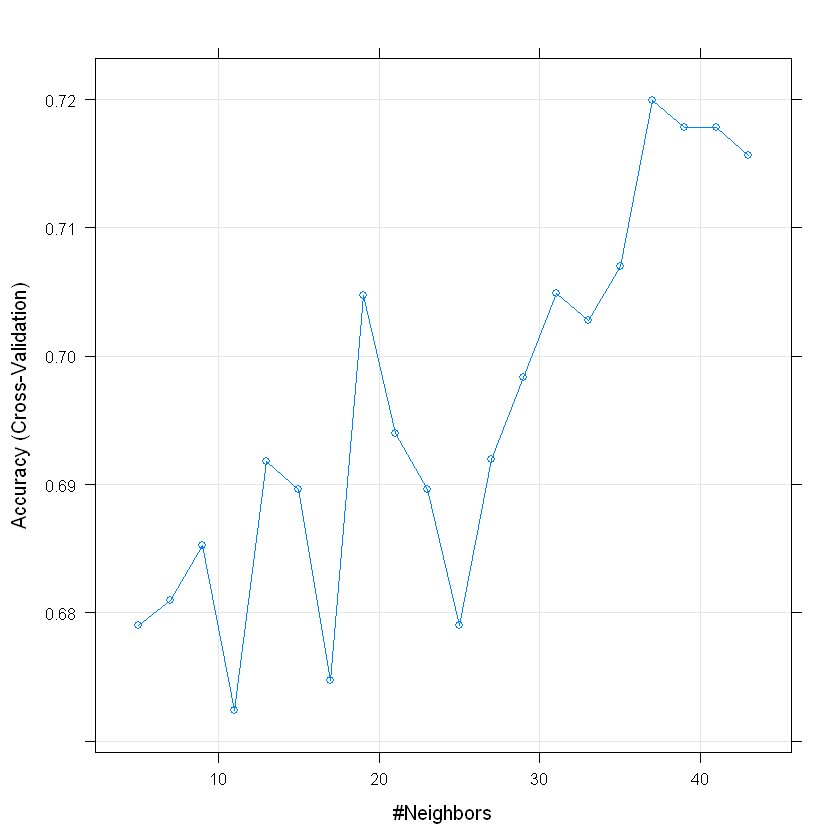

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                8            11
  liver_disease                  25            71
                                          
               Accuracy : 0.687           
                 95% CI : (0.5938, 0.7702)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.76681         
                                          
                  Kappa : 0.124           
                                          
 Mcnemar's Test P-Value : 0.03026         
                                          
            Sensitivity : 0.24242         
            Specificity : 0.86585         
         Pos Pred Value : 0.42105         
         Neg Pred Value : 0.73958         
             Prevalence : 0.28696         
         Detection Rate : 0.06957         
   Detection Prevalence : 0.16522         
      Balanced Accuracy : 0.55414         
               

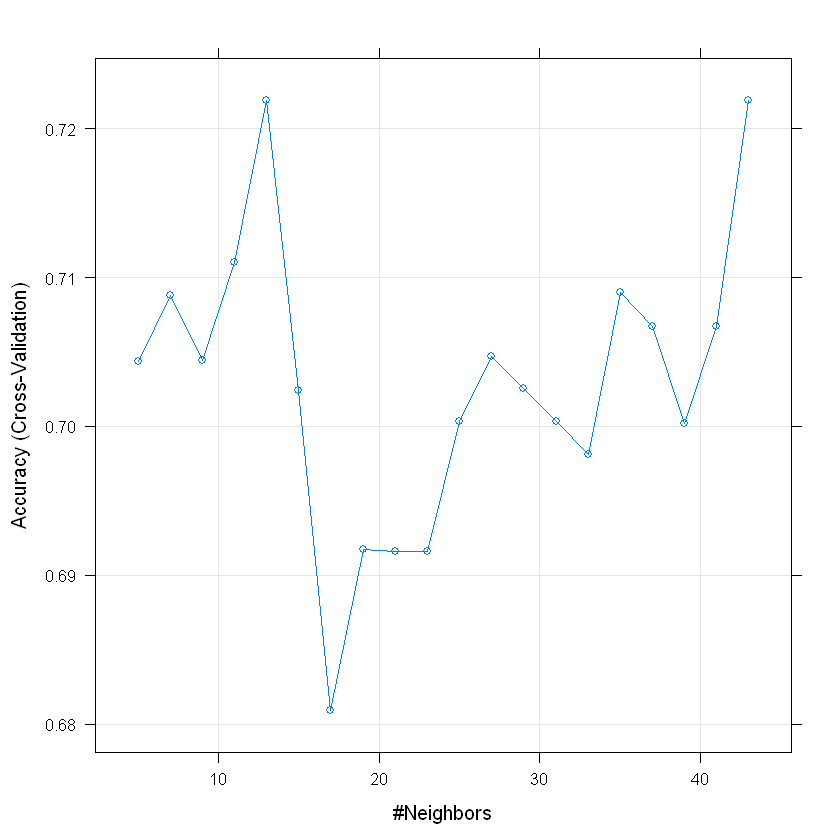

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                5            19
  liver_disease                  28            63
                                          
               Accuracy : 0.5913          
                 95% CI : (0.4957, 0.6821)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.9981          
                                          
                  Kappa : -0.0873         
                                          
 Mcnemar's Test P-Value : 0.2432          
                                          
            Sensitivity : 0.15152         
            Specificity : 0.76829         
         Pos Pred Value : 0.20833         
         Neg Pred Value : 0.69231         
             Prevalence : 0.28696         
         Detection Rate : 0.04348         
   Detection Prevalence : 0.20870         
      Balanced Accuracy : 0.45990         
               

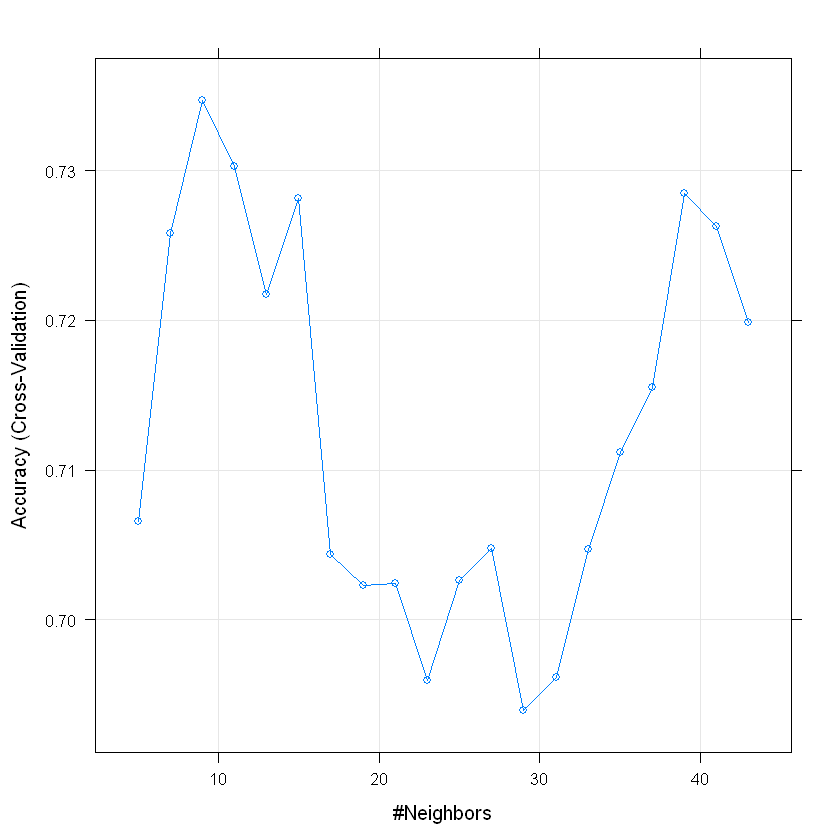

In [46]:
#KNN Neighbors
training.samples <- df.o$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o[ training.samples,]
df.Test  <- df.o[-training.samples,]
#Original Dataframe
# Model
model.knn.o <- train(
  Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Total_Protiens + Albumin + Age, data = df.Train, method = "knn",
  trControl = trainControl("cv", number = 10),
  preProcess = c("center","scale"), #no for categoric
  tuneLength = 20)
plot(model.knn.o)
# Prediction
predicted.classes <- model.knn.o %>% predict(df.Test)
matrix.knn.o <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.knn.o
#Dataset with fitted extreme outliers:
training.samples <- df.o.wo$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o.wo[ training.samples,]
df.Test  <- df.o.wo[-training.samples,]
# Model
model.knn.o.wo <- train(
  Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Total_Protiens + Age, data = df.Train, method = "knn",
  trControl = trainControl("cv", number = 10),
  preProcess = c("center","scale"), #no for categoric
  tuneLength = 20)
plot(model.knn.o.wo)
# Prediction
predicted.classes <- model.knn.o.wo %>% predict(df.Test)
matrix.knn.o.wo <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.knn.o.wo
#Clustered Datatframe
# df.cat.f
training.samples <- df.cat.f$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.cat.f[ training.samples,]
df.Test  <- df.cat.f[-training.samples,]
# Model
model.knn.cat.f <- train(
  Dataset ~ Direct_Bilirubin_ + Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + Albumin_ + AST_ALT_ratio_ + Age, data = df.Train, method = "knn",
  trControl = trainControl("cv", number = 10),
  tuneLength = 20)
plot(model.knn.cat.f)
# Prediction
predicted.classes <- model.knn.cat.f %>% predict(df.Test)
matrix.knn.cat.f <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.knn.cat.f




Classification tree:
rpart(formula = Dataset ~ Direct_Bilirubin + Alkaline_Phosphotase + 
    Alamine_Aminotransferase + Age, data = df.Train, method = "class")

Variables actually used in tree construction:
[1] Age                      Alamine_Aminotransferase Alkaline_Phosphotase    
[4] Direct_Bilirubin        

Root node error: 132/464 = 0.28448

n= 464 

        CP nsplit rel error xerror     xstd
1 0.030303      0   1.00000 1.0000 0.073625
2 0.020202      3   0.90909 1.1061 0.075780
3 0.018939      7   0.82576 1.1136 0.075920
4 0.015152      9   0.78788 1.1136 0.075920
5 0.011364     14   0.68939 1.2121 0.077565
6 0.010000     18   0.64394 1.2348 0.077901


Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease               15            17
  liver_disease                  18            65
                                          
               Accuracy : 0.6957          
                 95% CI : (0.6029, 0.778) 
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.7005          
                                          
                  Kappa : 0.2495          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.4545          
            Specificity : 0.7927          
         Pos Pred Value : 0.4688          
         Neg Pred Value : 0.7831          
             Prevalence : 0.2870          
         Detection Rate : 0.1304          
   Detection Prevalence : 0.2783          
      Balanced Accuracy : 0.6236          
               

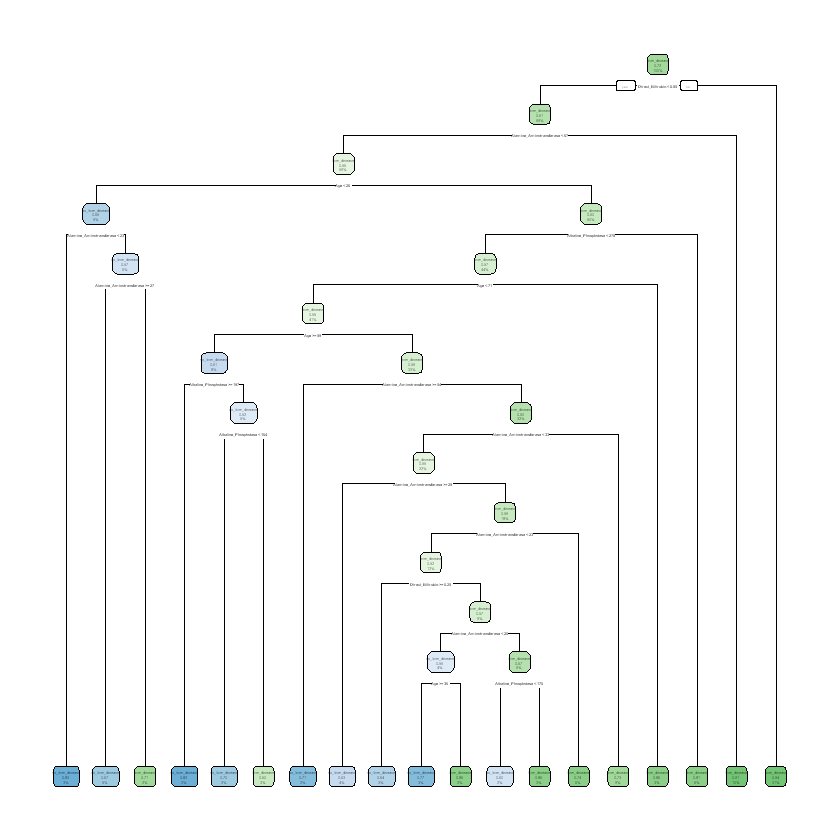


Classification tree:
rpart(formula = Dataset ~ Direct_Bilirubin + Alkaline_Phosphotase + 
    Alamine_Aminotransferase + Age, data = df.Train, method = "class")

Variables actually used in tree construction:
[1] Age                      Alamine_Aminotransferase Alkaline_Phosphotase    
[4] Direct_Bilirubin        

Root node error: 132/464 = 0.28448

n= 464 

        CP nsplit rel error  xerror     xstd
1 0.020833      0   1.00000 1.00000 0.073625
2 0.015152      9   0.78030 1.00000 0.073625
3 0.011364     12   0.73485 1.01515 0.073957
4 0.010000     16   0.68182 0.99242 0.073456


Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease               12            15
  liver_disease                  21            67
                                          
               Accuracy : 0.687           
                 95% CI : (0.5938, 0.7702)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.7668          
                                          
                  Kappa : 0.1911          
                                          
 Mcnemar's Test P-Value : 0.4047          
                                          
            Sensitivity : 0.3636          
            Specificity : 0.8171          
         Pos Pred Value : 0.4444          
         Neg Pred Value : 0.7614          
             Prevalence : 0.2870          
         Detection Rate : 0.1043          
   Detection Prevalence : 0.2348          
      Balanced Accuracy : 0.5904          
               


Classification tree:
rpart(formula = Dataset ~ Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + 
    Albumin_ + Age, data = df.Train, method = "class")

Variables actually used in tree construction:
[1] Age                       Alamine_Aminotransferase_
[3] Albumin_                  Alkaline_Phosphotase_    

Root node error: 132/464 = 0.28448

n= 464 

        CP nsplit rel error  xerror     xstd
1 0.075758      0   1.00000 1.00000 0.073625
2 0.045455      2   0.84848 0.99242 0.073456
3 0.011364      3   0.80303 0.96212 0.072759
4 0.010000      7   0.75758 1.04545 0.074596


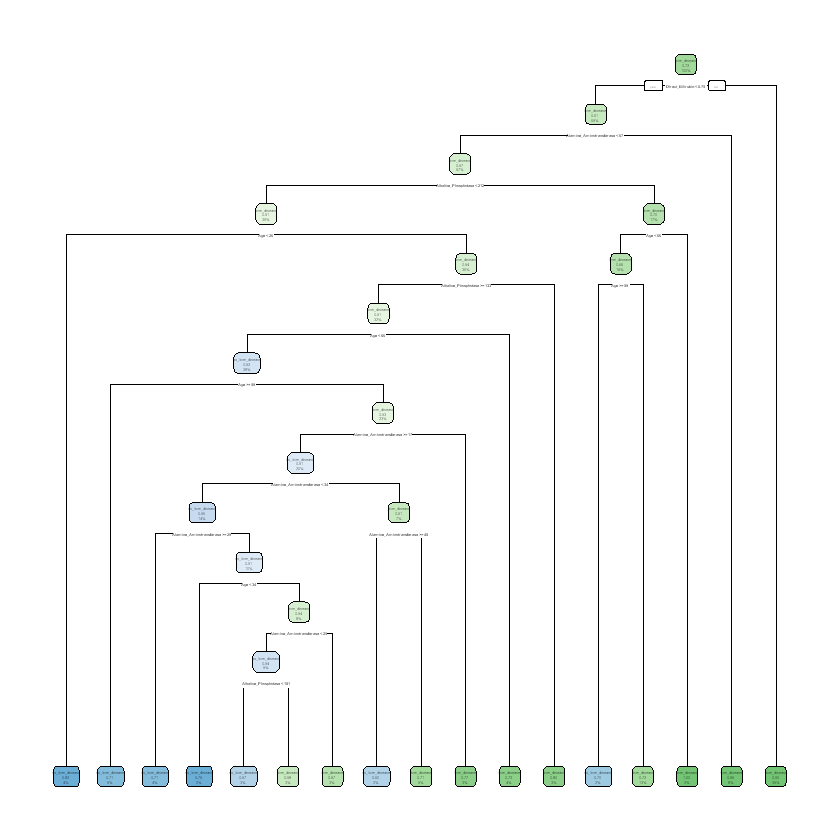

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                9            14
  liver_disease                  24            68
                                          
               Accuracy : 0.6696          
                 95% CI : (0.5757, 0.7544)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.8708          
                                          
                  Kappa : 0.1121          
                                          
 Mcnemar's Test P-Value : 0.1443          
                                          
            Sensitivity : 0.27273         
            Specificity : 0.82927         
         Pos Pred Value : 0.39130         
         Neg Pred Value : 0.73913         
             Prevalence : 0.28696         
         Detection Rate : 0.07826         
   Detection Prevalence : 0.20000         
      Balanced Accuracy : 0.55100         
               

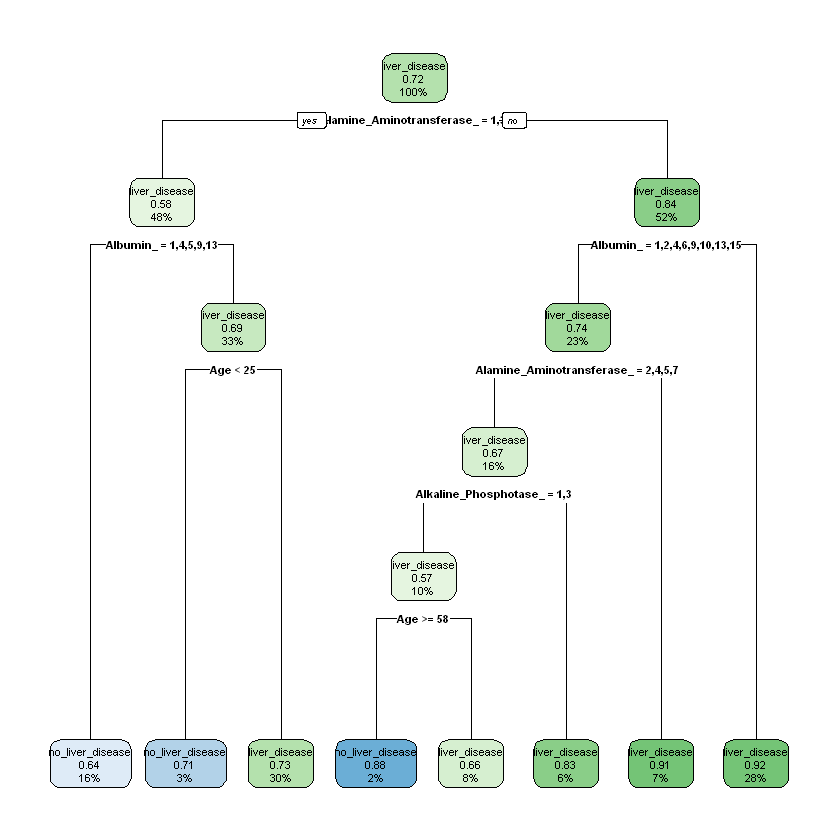

In [47]:
#CART analysis
#original dataframe
training.samples <- df.o$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o[ training.samples,]
df.Test  <- df.o[-training.samples,]
model.tree.o <- rpart(
  Dataset ~ Direct_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Age, data = df.Train, method = "class")
rpart.plot(model.tree.o, cex = NULL, tweak = 1, extra=108)
printcp(model.tree.o)
# Prediction
predicted.classes <- model.tree.o %>% predict(df.Test, type = "class")
matrix.tree.o <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.tree.o
#combo dataset
training.samples <- df.o.wo$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o.wo[ training.samples,]
df.Test  <- df.o.wo[-training.samples,]
# Model
model.tree.o.wo <- rpart(
  Dataset ~ Direct_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Age, data = df.Train, method = "class")
rpart.plot(model.tree.o.wo, cex = NULL, tweak = 1, extra=108)
printcp(model.tree.o.wo)
# Prediction
predicted.classes <- model.tree.o.wo %>% predict(df.Test, type = "class")
matrix.tree.o.wo <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.tree.o.wo
# clustered dataset
training.samples <- df.cat.f$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.cat.f[ training.samples,]
df.Test  <- df.cat.f[-training.samples,]
# Model
model.tree.cat.f <- rpart(
  Dataset ~ Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + Albumin_ + Age, data = df.Train, method = "class")
printcp(model.tree.cat.f)
rpart.plot(model.tree.cat.f, cex = NULL, tweak = 1, extra=108)
# Prediction
predicted.classes <- model.tree.cat.f %>% predict(df.Test, type = "class")
matrix.tree.cat.f <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.tree.cat.f


Call:
 randomForest(x = x, y = y, mtry = param$mtry, importance = FALSE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 27.8%
Confusion matrix:
                 no_liver_disease liver_disease class.error
no_liver_disease               53            79   0.5984848
liver_disease                  50           282   0.1506024

rf variable importance

                           Overall
Alamine_Aminotransferase    100.00
Age                          88.44
Aspartate_Aminotransferase   85.10
Alkaline_Phosphotase         84.16
Albumin                      32.59
Total_Bilirubin              28.66
Direct_Bilirubin              2.37
Albumin_and_Globulin_Ratio    0.00

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                5            13
  liver_disease                  28            69
                                          
               Accuracy : 0.6435          
                 95% CI : (0.5488, 0.7306)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.95787         
                                          
                  Kappa : -0.0081         
                                          
 Mcnemar's Test P-Value : 0.02878         
                                          
            Sensitivity : 0.15152         
            Specificity : 0.84146         
         Pos Pred Value : 0.27778         
         Neg Pred Value : 0.71134         
             Prevalence : 0.28696         
         Detection Rate : 0.04348         
   Detection Prevalence : 0.15652         
      Balanced Accuracy : 0.49649         
               


Call:
 randomForest(x = x, y = y, mtry = param$mtry, importance = FALSE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 29.09%
Confusion matrix:
                 no_liver_disease liver_disease class.error
no_liver_disease               43            89   0.6742424
liver_disease                  46           286   0.1385542

rf variable importance

                           Overall
Alkaline_Phosphotase        100.00
Age                          92.43
Alamine_Aminotransferase     81.88
Aspartate_Aminotransferase   65.20
Total_Bilirubin              64.97
Albumin                      29.00
Albumin_and_Globulin_Ratio    0.00

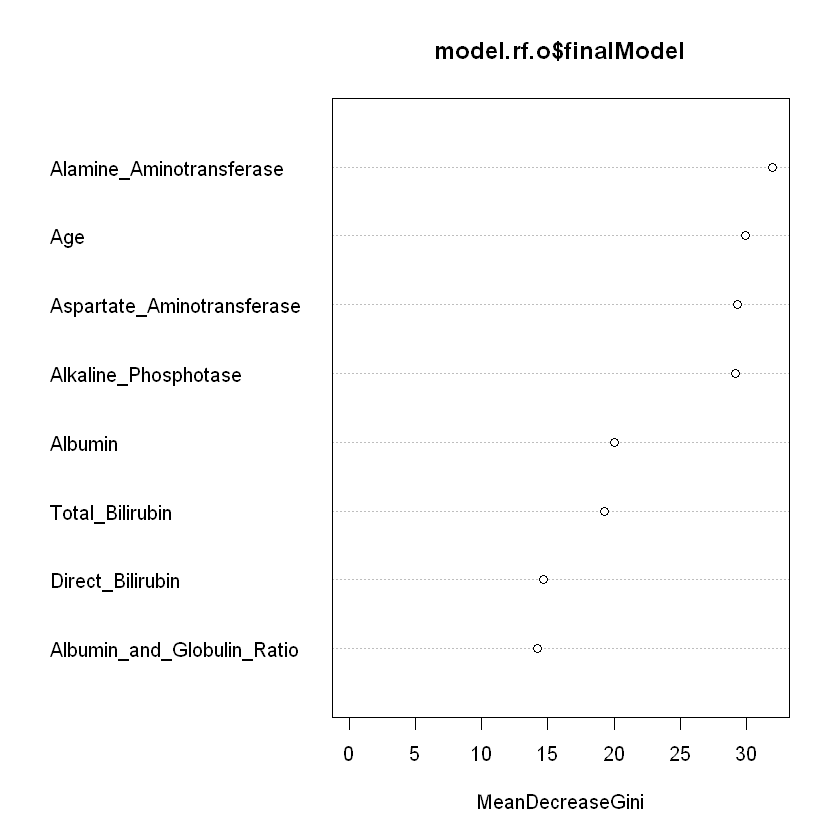

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                9            16
  liver_disease                  24            66
                                          
               Accuracy : 0.6522          
                 95% CI : (0.5577, 0.7386)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.9368          
                                          
                  Kappa : 0.0837          
                                          
 Mcnemar's Test P-Value : 0.2684          
                                          
            Sensitivity : 0.27273         
            Specificity : 0.80488         
         Pos Pred Value : 0.36000         
         Neg Pred Value : 0.73333         
             Prevalence : 0.28696         
         Detection Rate : 0.07826         
   Detection Prevalence : 0.21739         
      Balanced Accuracy : 0.53880         
               


Call:
 randomForest(x = x, y = y, mtry = param$mtry, importance = FALSE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 27.8%
Confusion matrix:
                 no_liver_disease liver_disease class.error
no_liver_disease                5           127 0.962121212
liver_disease                   2           330 0.006024096

rf variable importance

  only 20 most important variables shown (out of 33)

                           Overall
Age                        100.000
Direct_Bilirubin_2          63.023
Alamine_Aminotransferase_6  47.406
Alamine_Aminotransferase_3  38.099
Alkaline_Phosphotase_2      29.173
Direct_Bilirubin_5          28.683
Alkaline_Phosphotase_3      23.696
Albumin_4                   22.925
Albumin_11                  18.189
Direct_Bilirubin_4          14.318
Alamine_Aminotransferase_7  12.374
Albumin_7                   11.847
Alamine_Aminotransferase_4  11.041
Alamine_Aminotransferase_8   8.440
Albumin_6                    8.327
Alamine_Aminotransferase_2   7.987
Alkaline_Phosphotase_4       7.939
Albumin_9                    7.916
Albumin_3                    7.656
Alkaline_Phosphotase_5       7.294

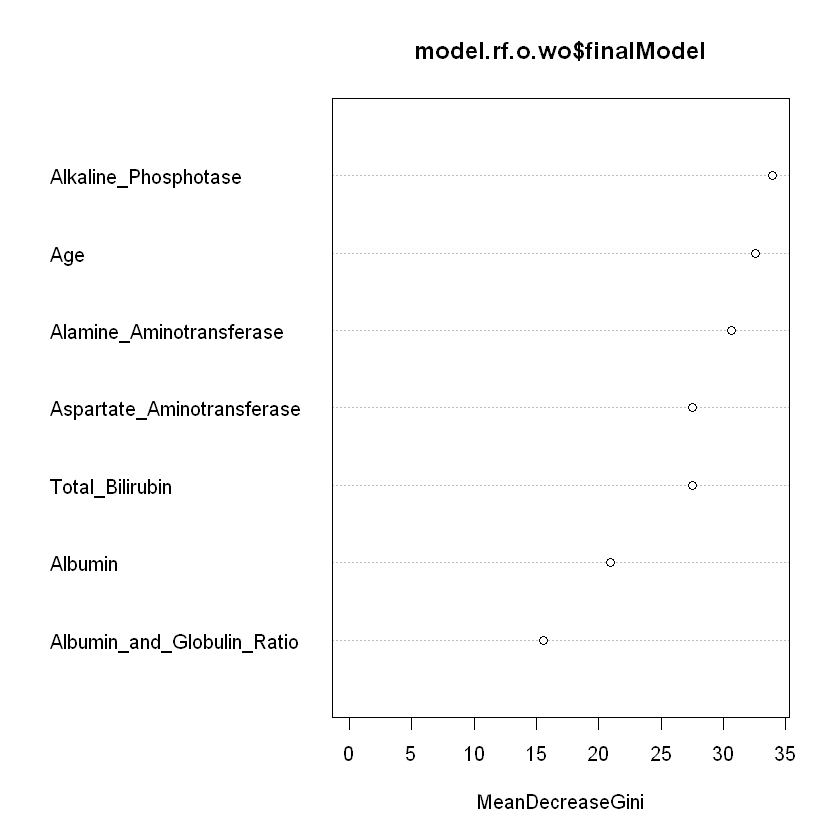

Confusion Matrix and Statistics

                  Reference
Prediction         no_liver_disease liver_disease
  no_liver_disease                1             0
  liver_disease                  32            82
                                          
               Accuracy : 0.7217          
                 95% CI : (0.6305, 0.8013)
    No Information Rate : 0.713           
    P-Value [Acc > NIR] : 0.4648          
                                          
                  Kappa : 0.0427          
                                          
 Mcnemar's Test P-Value : 4.251e-08       
                                          
            Sensitivity : 0.030303        
            Specificity : 1.000000        
         Pos Pred Value : 1.000000        
         Neg Pred Value : 0.719298        
             Prevalence : 0.286957        
         Detection Rate : 0.008696        
   Detection Prevalence : 0.008696        
      Balanced Accuracy : 0.515152        
               

               MLA              Dataframe Accuracy Number.of.Predictors
1  Log. Regression               ORIGINAL   0.7565              6 of 11
2  Log. Regression ORIGINAL VALUES FITTED   0.7391              6 of 11
3  Log. Regression ORIGINAL CATEGORIZATED   0.7739              7 of 11
4              KNN               ORIGINAL   0.7130              6 of 11
5              KNN ORIGINAL VALUES FITTED   0.6522              5 of 11
6              KNN ORIGINAL CATEGORIZATED   0.6957              6 of 11
7             CART               ORIGINAL   0.6870              4 of 11
8             CART ORIGINAL VALUES FITTED   0.6435              4 of 11
9             CART ORIGINAL CATEGORIZATED   0.6435              4 of 11
10   Random Forest               ORIGINAL   0.7391              8 of 11
11   Random Forest ORIGINAL VALUES FITTED   0.7304              7 of 11
12   Random Forest ORIGINAL CATEGORIZATED   0.7217              5 of 11


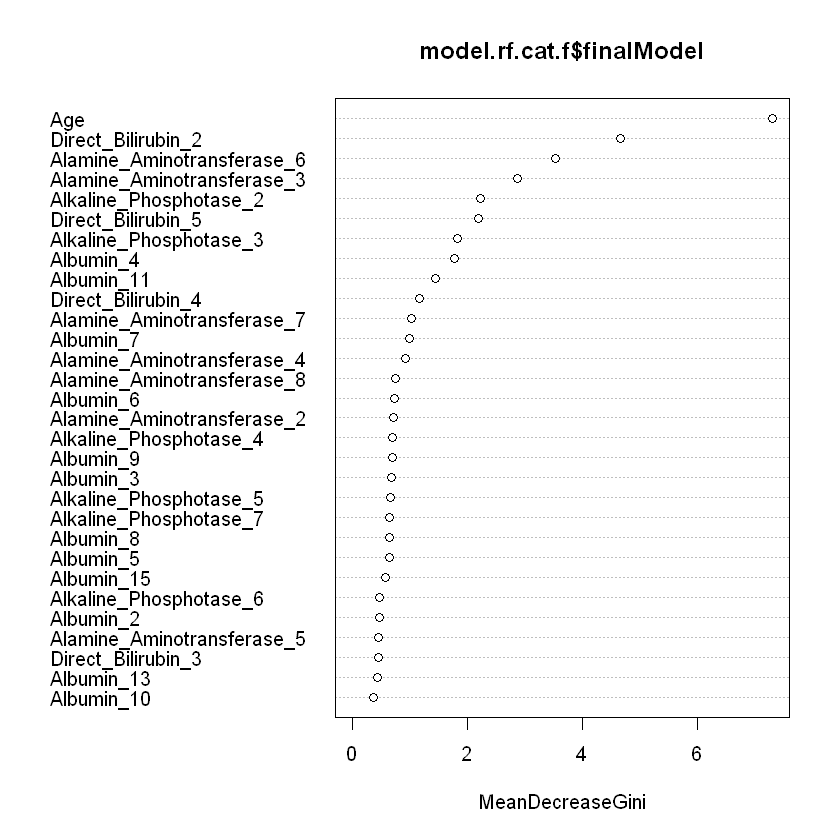

In [48]:
#randpm forest
#orignal data
training.samples <- df.o$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o[ training.samples,]
df.Test  <- df.o[-training.samples,]
# Model
model.rf.o <- train(
  Dataset ~ Direct_Bilirubin + Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Albumin + Age + Aspartate_Aminotransferase + Albumin_and_Globulin_Ratio, data = df.Train, method = "rf",
  trControl = trainControl("cv", number = 10),
  importance = FALSE
)
model.rf.o$finalModel
# Plot MeanDecreaseGini
varImpPlot(model.rf.o$finalModel, type = 2)
varImp(model.rf.o)
# Prediction
predicted.classes <- model.rf.o %>% predict(df.Test)
matrix.rf.o <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.rf.o
#orginal with extemes fitted
training.samples <- df.o.wo$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.o.wo[ training.samples,]
df.Test  <- df.o.wo[-training.samples,]
# Model
model.rf.o.wo <- train(
  Dataset ~ Total_Bilirubin + Alkaline_Phosphotase + Alamine_Aminotransferase + Albumin + Aspartate_Aminotransferase + Albumin_and_Globulin_Ratio + Age, data = df.Train, method = "rf",
  trControl = trainControl("cv", number = 10),
  importance = FALSE)
model.rf.o.wo$finalModel
# Variable Importance
varImp(model.rf.o.wo)
# Plot MeanDecreaseGini
varImpPlot(model.rf.o.wo$finalModel, type = 2)
# Prediction
predicted.classes <- model.rf.o.wo %>% predict(df.Test)
matrix.rf.o.wo <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.rf.o.wo
#clustered origninal
training.samples <- df.cat.f$Dataset %>% 
  createDataPartition(p = 0.8, list = FALSE)
df.Train <- df.cat.f[ training.samples,]
df.Test  <- df.cat.f[-training.samples,]
# Model
model.rf.cat.f <- train(
  Dataset ~ Direct_Bilirubin_ + Alkaline_Phosphotase_ + Alamine_Aminotransferase_ + Age + Albumin_, data = df.Train, method = "rf",
  trControl = trainControl("cv", number = 10),
  importance = FALSE)
model.rf.cat.f$finalModel
# Variable Importance
varImp(model.rf.cat.f)
# Plot MeanDecreaseGini
varImpPlot(model.rf.cat.f$finalModel, type = 2)
# Prediction
predicted.classes <- model.rf.cat.f %>% predict(df.Test)
matrix.rf.cat.f <- confusionMatrix(predicted.classes, df.Test$Dataset)
matrix.rf.cat.f
x <- data.frame("MLA" = c("Log. Regression", "Log. Regression", "Log. Regression", "KNN", "KNN", "KNN", "CART", "CART", "CART", "Random Forest", "Random Forest", "Random Forest"),
                "Dataframe" = c("ORIGINAL", "ORIGINAL VALUES FITTED", "ORIGINAL CATEGORIZATED", "ORIGINAL", "ORIGINAL VALUES FITTED", "ORIGINAL CATEGORIZATED", "ORIGINAL", "ORIGINAL VALUES FITTED", "ORIGINAL CATEGORIZATED", "ORIGINAL", "ORIGINAL VALUES FITTED", "ORIGINAL CATEGORIZATED"),
                "Accuracy" = c(0.7565, 0.7391, 0.7739, 0.713, 0.6522, 0.6957, 0.687, 0.6435, 0.6435, 0.7391, 0.7304, 0.7217),
                "Number of Predictors" = c("6 of 11", "6 of 11", "7 of 11", "6 of 11", "5 of 11", "6 of 11", "4 of 11", "4 of 11", "4 of 11", "8 of 11", "7 of 11", "5 of 11"))
print(x)

In [52]:
df$Gender

[1] Female Male   Male   Male   Male   Male   Female Female Male   Male  
 [11] Male   Male   Male   Female Male   Male   Male   Male   Female Female
 [21] Male   Male   Male   Male   Male   Male   Male   Male   Male   Female
 [31] Male   Male   Male   Female Female Male   Female Female Male   Male  
 [41] Male   Male   Male   Male   Female Male   Male   Male   Female Male  
 [51] Female Female Male   Male   Male   Male   Male   Female Male   Male  
 [61] Female Male   Male   Male   Male   Male   Male   Male   Male   Male  
 [71] Female Female Female Male   Male   Female Male   Female Male   Female
 [81] Female Male   Male   Male   Male   Male   Male   Male   Male   Male  
 [91] Male   Male   Male   Male   Male   Male   Male   Male   Male   Male  
[101] Male   Male   Male   Female Male   Male   Male   Male   Male   Male  
[111] Female Male   Male   Male   Male   Male   Male   Male   Male   Male  
[121] Male   Male   Male   Female Male   Male   Male   Male   Female Male  
[131] Male   Female Female Male   Male   Male   Female Male   Male   Male  
[141] Male   Female Male   Male   Female Male   Female Male   Male   Male  
[151] Male   Male   Female Male   Male   Male   Male   Male   Male   Male  
[161] Male   Male   Male   Male   Male   Male   Male   Female Male   Male  
[171] Male   Female Male   Male   Male   Male   Male   Male   Male   Male  
[181] Male   Male   Male   Male   Male   Male   Male   Male   Male   Female
[191] Male   Male   Male   Male   Male   Male   Male   Female Male   Female
[201] Male   Male   Female Male   Male   Male   Male   Male   Female Male  
[211] Male   Male   Female Male   Male   Male   Male   Male   Male   Male  
[221] Male   Male   Male   Male   Male   Male   Female Female Male   Male  
[231] Male   Male   Male   Female Male   Male   Female Female Male   Male  
[241] Female Female Male   Male   Male   Male   Male   Male   Male   Male  
[251] Male   Female Male   Male   Male   Male   Male   Male   Male   Male  
[261] Female Male   Male   Male   Female Male   Male   Male   Male   Male  
[271] Male   Male   Male   Male   Male   Male   Female Male   Male   Male  
[281] Male   Male   Male   Female Male   Female Male   Female Male   Male  
[291] Male   Male   Male   Female Female Female Female Male   Female Female
[301] Male   Female Female Male   Male   Female Female Male   Female Female
[311] Male   Male   Male   Male   Male   Male   Female Female Male   Male  
[321] Male   Male   Female Male   Male   Male   Male   Male   Male   Female
[331] Female Female Male   Male   Male   Male   Male   Female Male   Male  
[341] Male   Male   Male   Male   Male   Female Male   Male   Female Female
[351] Female Male   Male   Male   Male   Female Male   Female Male   Female
[361] Male   Male   Male   Male   Female Female Female Male   Male   Female
[371] Female Male   Male   Female Female Male   Male   Male   Female Female
[381] Male   Male   Male   Male   Male   Male   Male   Male   Male   Male  
[391] Female Male   Male   Male   Male   Male   Female Male   Female Male  
[401] Male   Female Male   Male   Male   Male   Male   Female Male   Male  
[411] Male   Male   Male   Male   Male   Female Female Male   Male   Male  
[421] Female Male   Male   Male   Female Male   Female Female Male   Female
[431] Female Female Male   Male   Male   Female Female Female Female Female
[441] Male   Male   Male   Female Female Female Male   Male   Male   Male  
[451] Male   Female Male   Male   Male   Male   Female Female Male   Male  
[461] Female Female Female Female Male   Male   Male   Female Male   Male  
[471] Male   Male   Male   Male   Male   Male   Male   Male   Male   Male  
[481] Male   Female Female Male   Male   Male   Female Male   Female Male  
[491] Male   Male   Male   Male   Male   Male   Male   Male   Male   Male  
[501] Male   Male   Male   Male   Male   Male   Female Male   Male   Male  
[511] Male   Male   Male   Male   Male   Male   Male   Male   Female Male  
[521] Male   Female Male   Male   Male   Male   Fe

In [54]:
df.m

Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,liver_disease
62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,liver_disease
58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,liver_disease
72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,liver_disease
46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,liver_disease
17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,no_liver_disease
55,Male,0.7,0.2,290,53,58,6.8,3.4,1.00,liver_disease
57,Male,0.6,0.1,210,51,59,5.9,2.7,0.80,liver_disease
72,Male,2.7,1.3,260,31,56,7.4,3.0,0.60,liver_disease
64,Male,0.9,0.3,310,61,58,7.0,3.4,0.90,no_liver_disease


In [61]:
names(df.o)

[1] "Age"                        "Gender"                    
 [3] "Total_Bilirubin"            "Direct_Bilirubin"          
 [5] "Alkaline_Phosphotase"       "Alamine_Aminotransferase"  
 [7] "Aspartate_Aminotransferase" "Total_Protiens"            
 [9] "Albumin"                    "Albumin_and_Globulin_Ratio"
[11] "AST_ALT_ratio"              "Dataset"

In [62]:
df$Dataset

[1] liver_disease    liver_disease    liver_disease    liver_disease   
  [5] liver_disease    liver_disease    liver_disease    liver_disease   
  [9] no_liver_disease liver_disease    liver_disease    liver_disease   
 [13] no_liver_disease liver_disease    liver_disease    no_liver_disease
 [17] liver_disease    no_liver_disease liver_disease    liver_disease   
 [21] liver_disease    liver_disease    liver_disease    liver_disease   
 [25] no_liver_disease liver_disease    liver_disease    liver_disease   
 [29] no_liver_disease no_liver_disease liver_disease    liver_disease   
 [33] no_liver_disease no_liver_disease no_liver_disease liver_disease   
 [37] no_liver_disease liver_disease    liver_disease    liver_disease   
 [41] liver_disease    no_liver_disease no_liver_disease liver_disease   
 [45] no_liver_disease no_liver_disease liver_disease    liver_disease   
 [49] liver_disease    liver_disease    liver_disease    liver_disease   
 [53] liver_disease    liver_disease    liver_disease    liver_disease   
 [57] no_liver_disease no_liver_disease liver_disease    no_liver_disease
 [61] liver_disease    liver_disease    liver_disease    liver_disease   
 [65] liver_disease    liver_disease    liver_disease    liver_disease   
 [69] liver_disease    no_liver_disease liver_disease    liver_disease   
 [73] liver_disease    liver_disease    liver_disease    no_liver_disease
 [77] liver_disease    liver_disease    no_liver_disease liver_disease   
 [81] liver_disease    liver_disease    no_liver_disease liver_disease   
 [85] liver_disease    liver_disease    no_liver_disease liver_disease   
 [89] liver_disease    liver_disease    liver_disease    liver_disease   
 [93] liver_disease    liver_disease    liver_disease    liver_disease   
 [97] liver_disease    liver_disease    liver_disease    liver_disease   
[101] no_liver_disease no_liver_disease liver_disease    no_liver_disease
[105] liver_disease    no_liver_disease no_liver_disease no_liver_disease
[109] no_liver_disease no_liver_disease no_liver_disease liver_disease   
[113] no_liver_disease liver_disease    no_liver_disease no_liver_disease
[117] liver_disease    liver_disease    liver_disease    liver_disease   
[121] liver_disease    liver_disease    no_liver_disease liver_disease   
[125] no_liver_disease no_liver_disease liver_disease    liver_disease   
[129] liver_disease    liver_disease    liver_disease    no_liver_disease
[133] no_liver_disease liver_disease    liver_disease    liver_disease   
[137] liver_disease    liver_disease    liver_disease    liver_disease   
[141] no_liver_disease liver_disease    liver_disease    liver_disease   
[145] liver_disease    no_liver_disease liver_disease    liver_disease   
[149] liver_disease    liver_disease    no_liver_disease liver_disease   
[153] liver_disease    no_liver_disease liver_disease    liver_disease   
[157] liver_disease    liver_disease    liver_disease    liver_disease   
[161] liver_disease    liver_disease    liver_disease    liver_disease   
[165] liver_disease    liver_disease    liver_disease    liver_disease   
[169] liver_disease    liver_disease    liver_disease    liver_disease   
[173] liver_disease    liver_disease    liver_disease    liver_disease   
[177] liver_disease    liver_disease    liver_disease    liver_disease   
[181] liver_disease    liver_disease    no_liver_disease liver_disease   
[185] liver_disease    no_liver_disease liver_disease    liver_disease   
[189] liver_disease    no_liver_disease liver_disease    liver_disease   
[193] liver_disease    no_liver_disease no_liver_disease liver_disease   
[197] liver_disease    liver_disease    no_liver_disease liver_disease   
[201] liver_disease    liver_disease    no_liver_disease no_liver_disease
[205] no_liver_disease liver_disease    liver_disease    liver_disease   
[209] liver_disease    liver_disease    liver_disease    no_liver_disease
[213] liver_disease    liver_disease    no_liver_disease no_liver_disease
[217] 

In [70]:
cor.test((as.factor(df$Gender))(as.fstor(df$Dataset)))

ERROR: Error in cor.test((as.factor(df$Gender))(as.fstor(df$Dataset))): attempt to apply non-function


In [72]:
results_wilcox

,wilcox.tests.o,wilcox.tests.o.log,wilcox.tests.o.wo
Total_Bilirubin,2.748439e-13,2.748439e-13,4.979732e-13
Direct_Bilirubin,6.449568e-13,6.449568e-13,8.72447e-13
Alkaline_Phosphotase,9.936943e-11,9.936943e-11,1.205418e-10
Alamine_Aminotransferase,3.702919e-12,3.702919e-12,4.594092e-12
Aspartate_Aminotransferase,1.310704e-13,1.310704e-13,1.386802e-13
Total_Protiens,0.446179,0.446179,0.4468362
Albumin,5.931425e-05,5.931425e-05,5.931425e-05
Albumin_and_Globulin_Ratio,5.812072e-06,5.812072e-06,5.690612e-06
Age,0.002731931,0.002731931,0.002731931
AST_ALT_ratio,0.05342674,0.05342674,0.05320489
